In [1]:
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy as sp
import statsmodels
from pandas_profiling import ProfileReport
from imblearn import FunctionSampler
from imblearn.pipeline import Pipeline, make_pipeline
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# To automatically reload module after src code changes
%load_ext autoreload
%autoreload 1
%aimport utilz.PandasTransformerWrapper, utilz.CachedRandomizedSearchCV, utilz.CategoryShrinker
from utilz.CategoryShrinker import CategoryShrinker
from utilz.CachedRandomizedSearchCV import CachedRandomizedSearchCV
from utilz.PandasColumnTransformer import PandasColumnTransformer

%matplotlib inline

In [2]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("utils.py"))))
from utils import resid_yhat_plot

In [3]:
X_train = pd.read_csv("./train.csv")
X_test = pd.read_csv("./test.csv")
y_train = X_train["SalePrice"]

X_train.drop(columns=["Id", "SalePrice"], inplace=True)
X_test.drop(columns=["Id"], inplace=True)
print(X_train.shape, X_test.shape)

X_train.head()

(1460, 79) (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
with open('./data_description.txt', 'r') as f:
    print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        60	2-STORY 1946 & NEWER
o        50	1-1/2 STORY FINISHED ALL AGES
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       R

## EDA
At this early point my goal is to determine what preprocessing is going to be applied. </br>
Naturally, the choices are not unique.

In [5]:
df = pd.concat([y_train, X_train], axis=1)
df.head()

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,208500,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,181500,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,223500,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,140000,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,250000,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [6]:
cat = X_train.select_dtypes(include="object")
cat_cols = np.array(cat.columns)
num_cols = np.array(list(set(X_train.columns) - set(cat.columns)))

def convert_to_cat(cols):
    pass

In [7]:
for cat_col in cat_cols:
    print(df[cat_col].value_counts(), "\n")

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64 

Pave    1454
Grvl       6
Name: Street, dtype: int64 

Grvl    50
Pave    41
Name: Alley, dtype: int64 

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64 

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64 

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64 

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64 

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64 

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neig

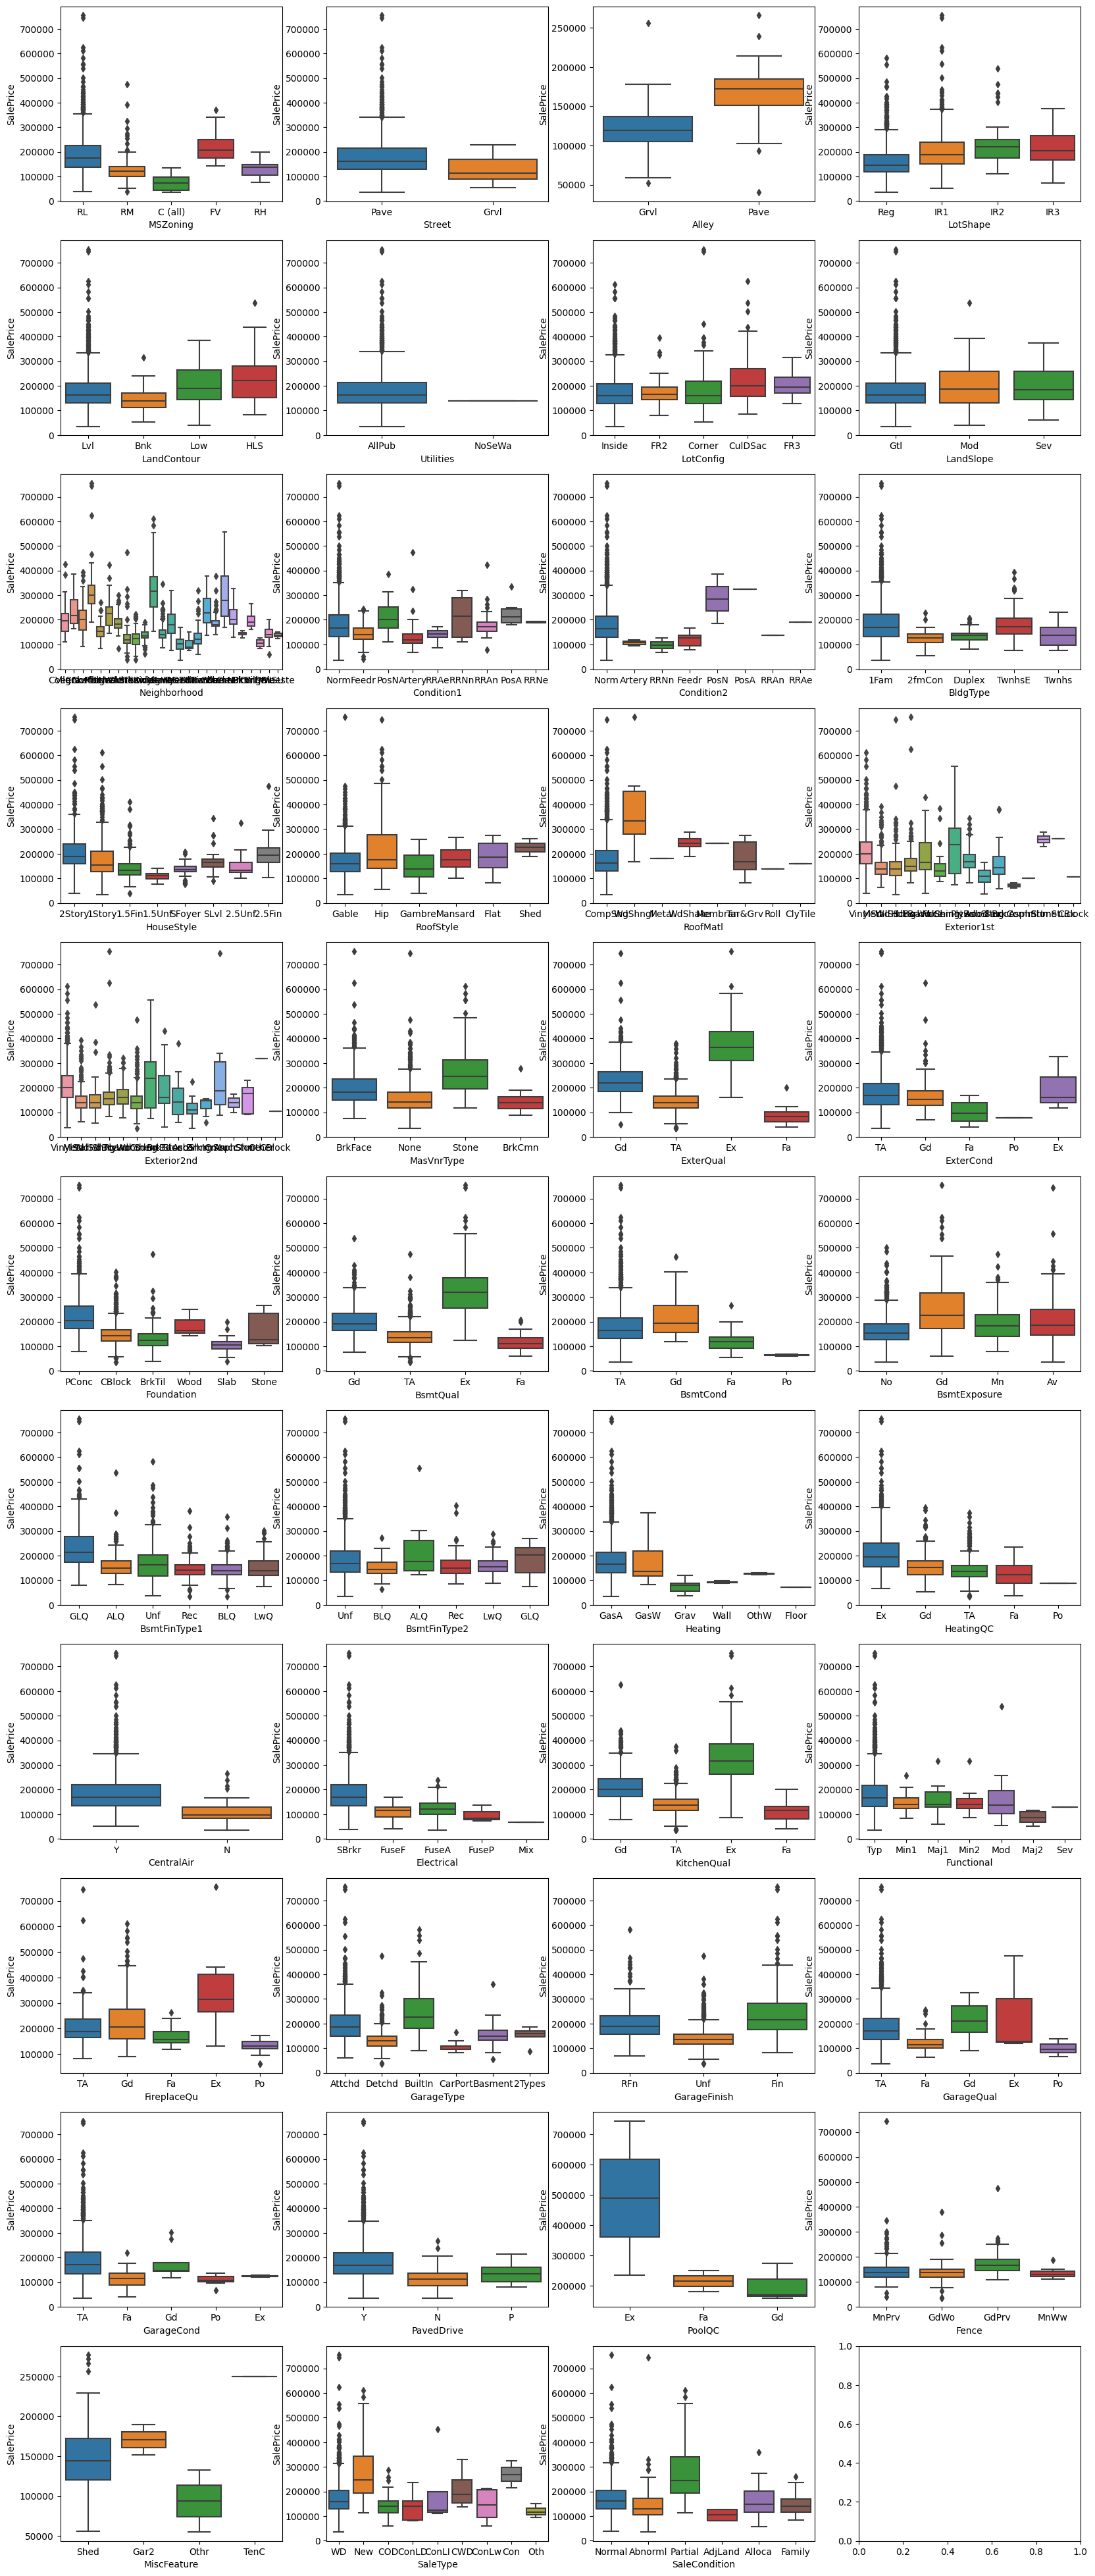

In [8]:
n_per_row = 4
f, axs = plt.subplots(
    int(np.ceil(len(cat_cols) / n_per_row)), 
    n_per_row, 
    figsize=(20, 50)
)

axs = axs.ravel()[:len(cat_cols)]

for ax, cat_col in zip(axs, cat_cols):
    sns.boxplot(y="SalePrice", x=cat_col, data=df, ax=ax)

<AxesSubplot:xlabel='price_log', ylabel='Neighborhood'>

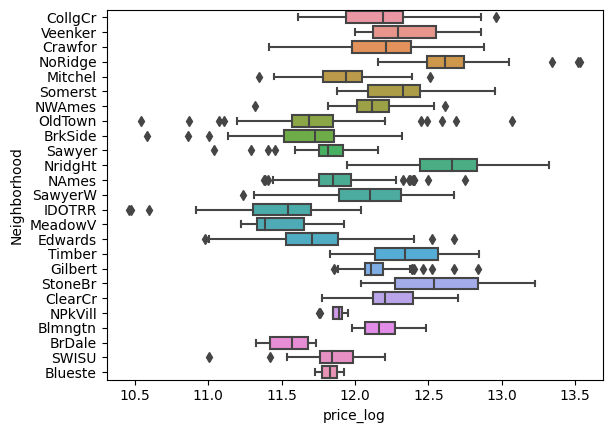

In [9]:
df["price_log"] = np.log(df["SalePrice"])
sns.boxplot(y="Neighborhood", x="price_log", data=df)

In [10]:
from sklearn.feature_selection import VarianceThreshold
var = VarianceThreshold().fit(X_train[num_cols])
var.variances_

array([2.13945000e+05, 1.23747420e+00, 5.52000000e+02, 6.00000000e+01,
       4.80000000e+02, 1.55000000e+04, 2.69083787e-01, 2.06500000e+03,
       7.30458810e+00, 5.89258120e+02, 6.65038000e-01, 5.47000000e+02,
       1.70000000e+02, 5.58097204e-01, 1.76262854e+00, 1.91136939e+00,
       7.38000000e+02, 2.33600000e+03, 4.15310096e-01, 2.64009383e+00,
       8.57000000e+02, 1.47400000e+03, 3.27623920e+04, 6.09140462e+02,
       5.64400000e+03, 4.85156690e-02, 3.03300338e-01, 5.08000000e+02,
       4.35800000e+03, 2.52720492e-01, 1.41800000e+03, 5.72000000e+02,
       5.30800000e+03, 6.11000000e+03, 5.69637831e-02, 1.38000000e+02])

In [11]:
critical_point = 10
low_var_cols = np.array(num_cols)[np.argwhere(var.variances_ < critical_point).ravel()]

for num_col in low_var_cols:
    print(df[num_col].value_counts().sort_values(ascending=False), "\n")

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64 

0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64 

6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64 

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64 

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64 

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64 

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64 

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64 

6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
2       1
14      1
Name: TotRmsAbvGrd, dtype: int64 

1    1392
2      65
3       2
0  

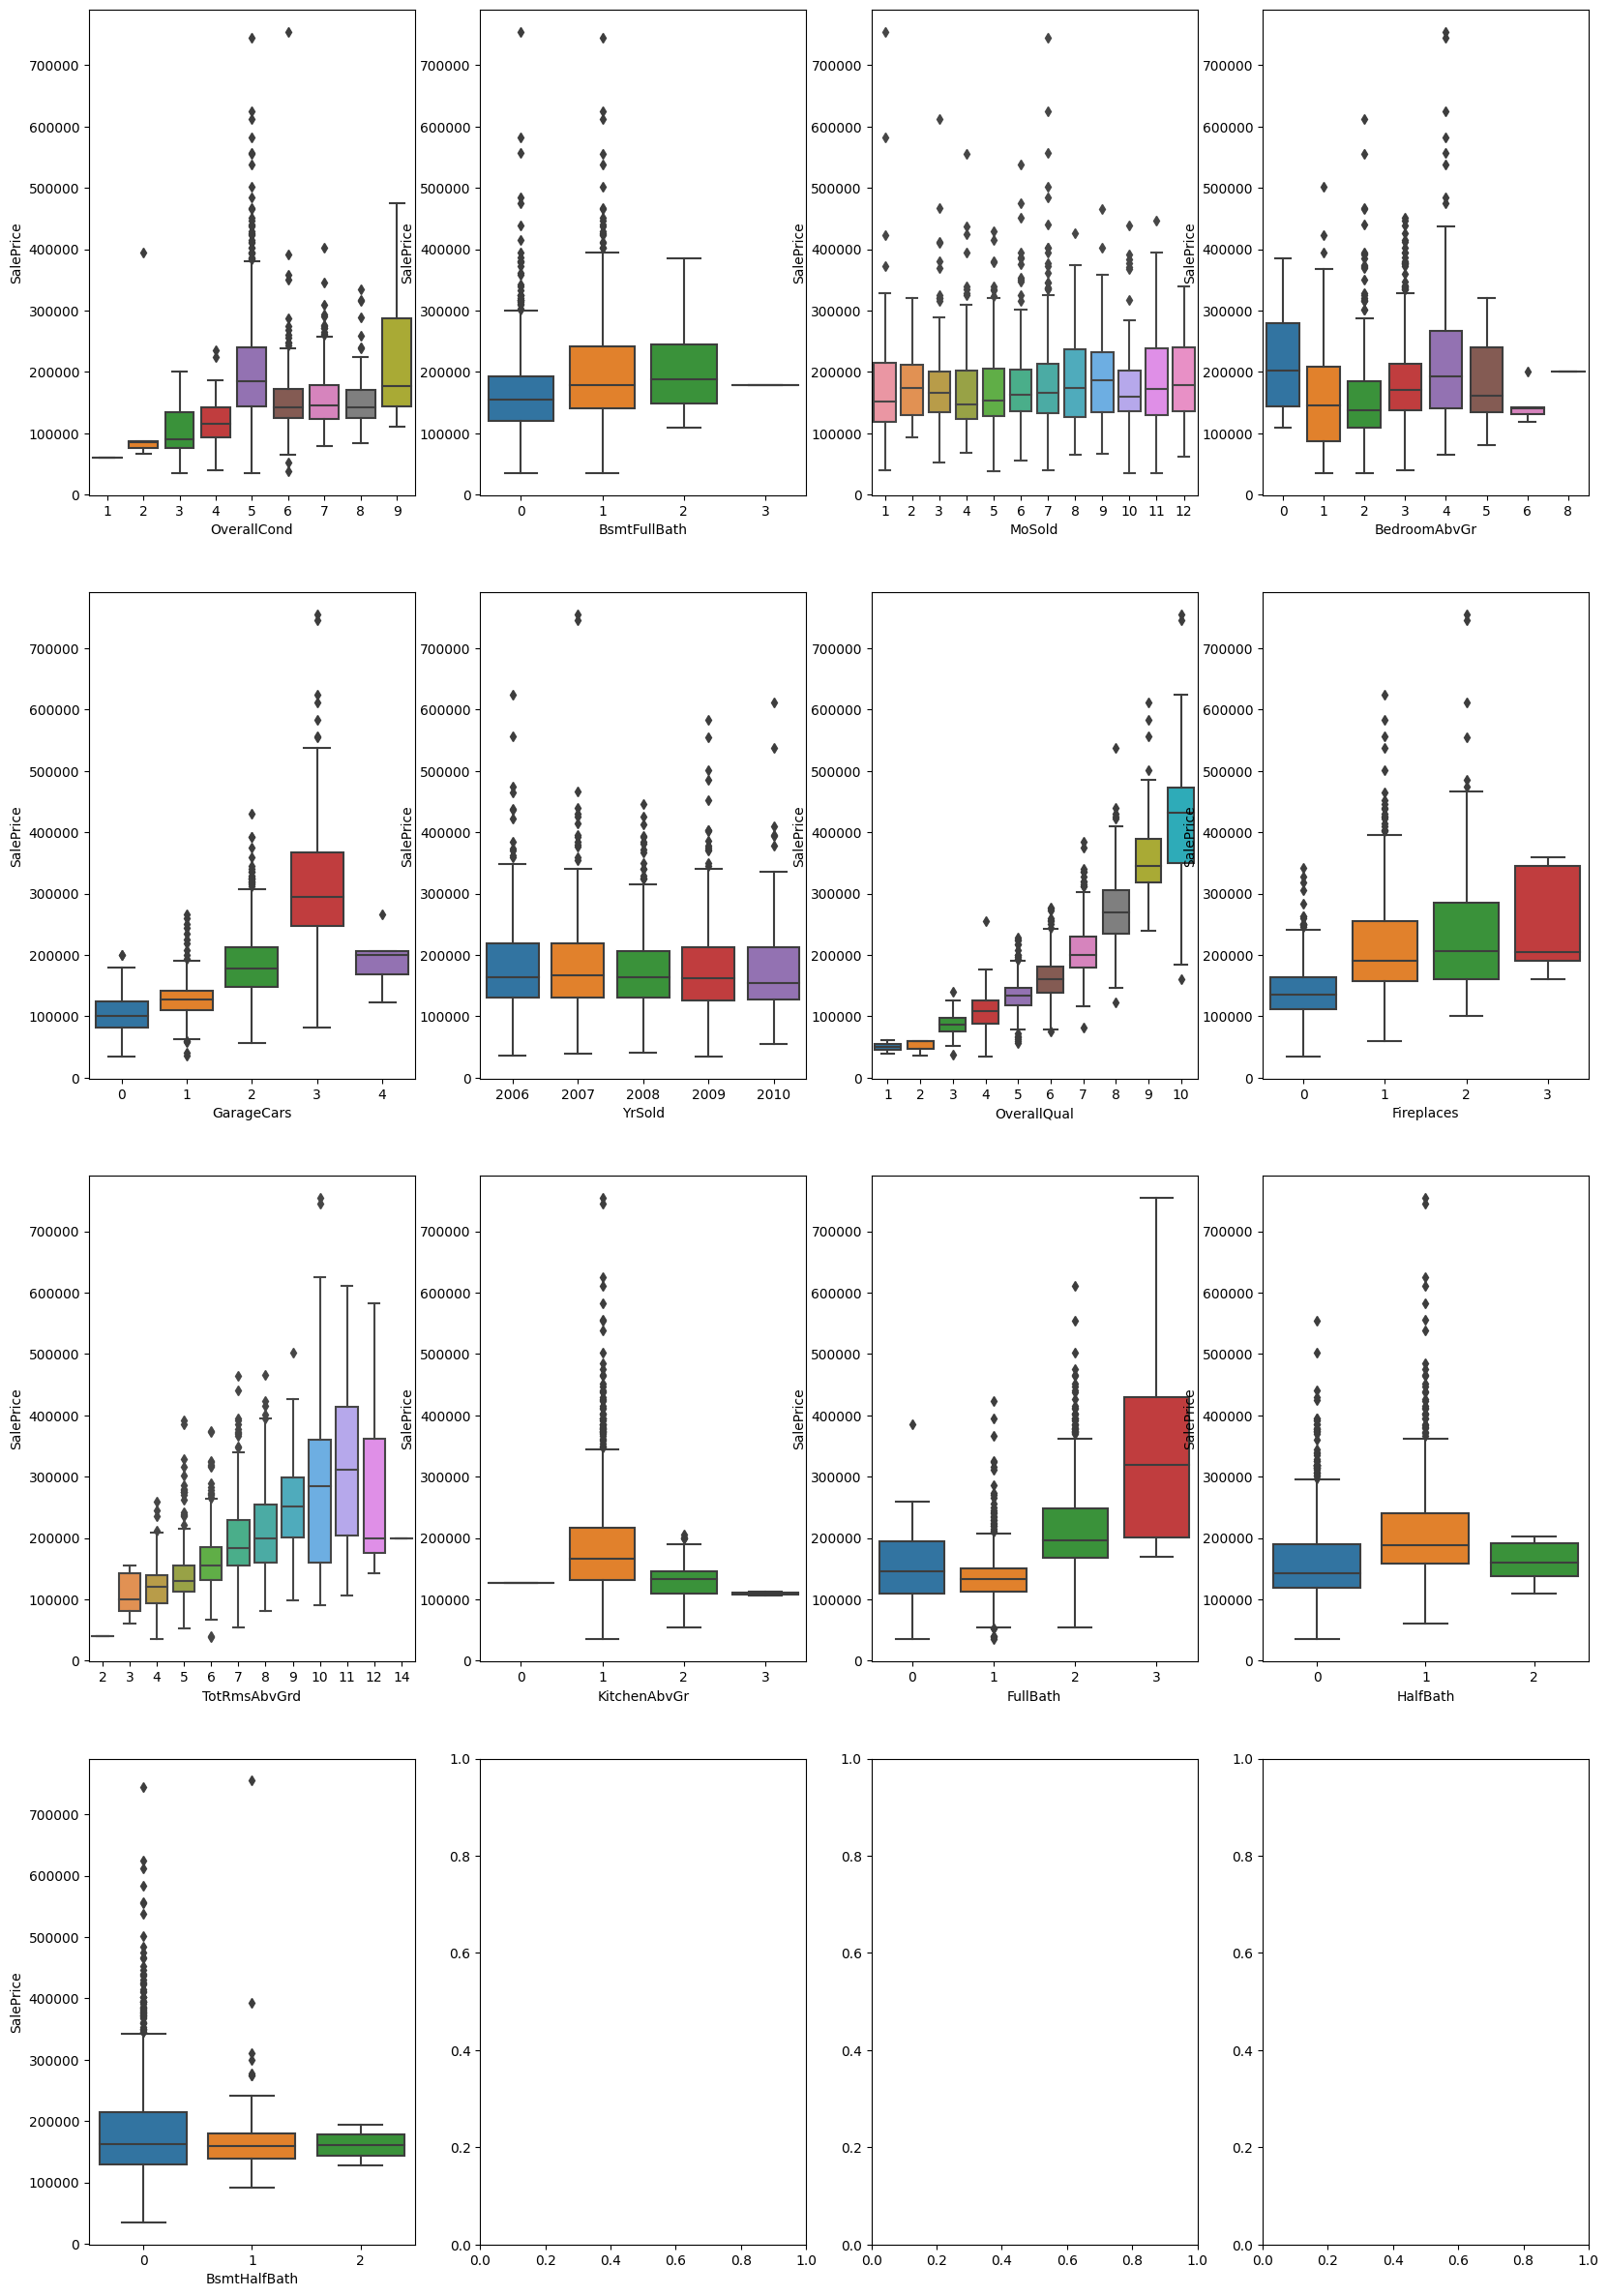

In [12]:
n_per_row = 4
f, axs = plt.subplots(
    int(np.ceil(len(low_var_cols) / n_per_row)), 
    n_per_row, 
    figsize=(20, 30)
)

axs = axs.ravel()[:len(low_var_cols)]

for ax, cat_col in zip(axs, low_var_cols):
    sns.boxplot(y="SalePrice", x=cat_col, data=df, ax=ax)

In [13]:
new_cat_cols = list(
    set(low_var_cols) - 
    set(["OverallQual", "TotRmsAbvGrd", "OverallCond"])
) 
cat_cols = np.append(cat_cols, new_cat_cols)
num_cols = np.setdiff1d(num_cols, new_cat_cols)
assert cat_cols.shape[0] + num_cols.shape[0] == X_train.shape[1]

In [14]:
other_num_columns = list(set(num_cols) - set(low_var_cols))
for num_col in other_num_columns:
    values = df[num_col].value_counts().sort_values(ascending=False) 
    
    if len(values) >= 10:
        l = len(values)
        values = values.iloc[:10]
        values["..."] = l - len(values)
        
    print(values, "\n")

7200       25
9600       24
6000       17
9000       14
8400       14
10800      14
1680       10
7500        9
6120        8
6240        8
...      1063
Name: LotArea, dtype: int64 

0      1252
112      15
96        6
192       5
144       5
120       5
216       5
156       4
116       4
252       4
...     110
Name: EnclosedPorch, dtype: int64 

1950    178
2006     97
2007     76
2005     73
2004     62
2000     55
2003     51
2002     48
2008     40
1996     36
...      51
Name: YearRemodAdd, dtype: int64 

0      1344
192       6
120       5
224       5
189       4
180       4
147       3
90        3
160       3
144       3
...      66
Name: ScreenPorch, dtype: int64 

0       1408
400       11
500        8
700        5
450        4
600        4
2000       4
1200       2
480        2
620        1
...       11
Name: MiscVal, dtype: int64 

0      829
728     10
504      9
672      8
546      8
600      7
720      7
896      6
862      5
780      5
...    407
Name: 2ndFlrSF, dtype

In [15]:
new_cat_cols = ["MSSubClass", "YearBuilt", "GarageYrBlt", "YearRemodAdd"]
cat_cols = np.append(cat_cols, new_cat_cols)
num_cols = np.setdiff1d(num_cols, new_cat_cols)
assert cat_cols.shape[0] + num_cols.shape[0] == X_train.shape[1]

In [16]:
num_cols

array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GrLivArea', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal',
       'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF'],
      dtype='<U13')

The only variables left are arias, ...

<AxesSubplot:>

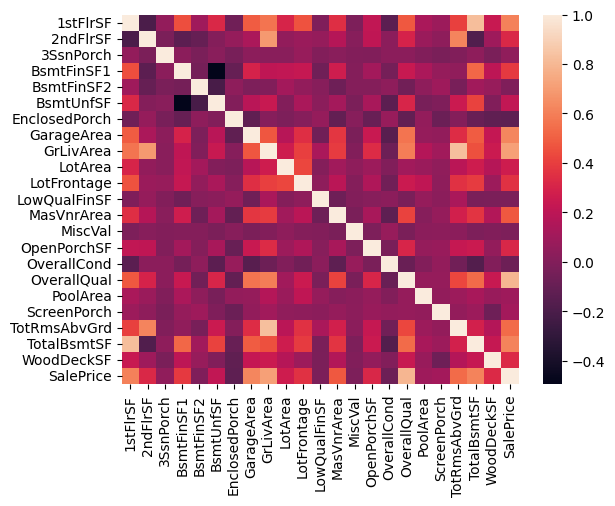

In [17]:
sns.heatmap(df[np.append(num_cols, ["SalePrice"])].corr())

Left-upper "quadrant":

In [18]:
# sns.pairplot(x_vars=num_cols[:10], y_vars=num_cols[:10], data=df)

Right-upper (equiv, left-lower) "quadrant":

In [19]:
# sns.pairplot(x_vars=num_cols[10:], y_vars=num_cols[:10], data=df)

Right-lower "quadrant":

In [20]:
# sns.pairplot(df[num_cols[10:]])

## Outlier

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<AxesSubplot:xlabel='price_log', ylabel='Count'>

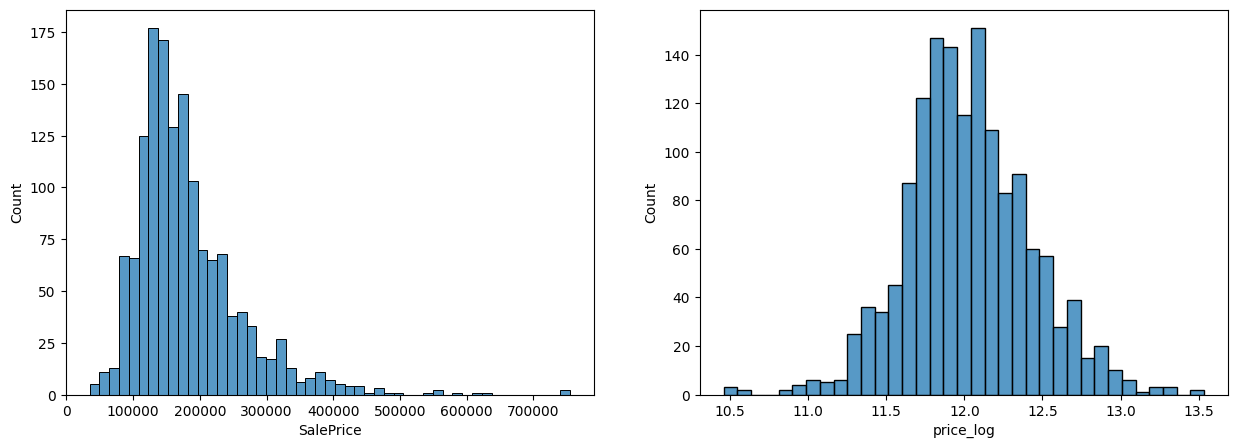

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
df["price_log"] = np.log(df["SalePrice"])
print(df["SalePrice"].describe())
sns.histplot(x="SalePrice", data=df, ax=ax1)
sns.histplot(x="price_log", data=df, ax=ax2)

In [22]:
mean, std = df["price_log"].mean(), df["price_log"].std()
price_outliers = df[(np.abs(df["price_log"]) > mean + 2*std)].index
df.iloc[price_outliers, :]

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,price_log
53,385000,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,12.860999
58,438780,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,12.991753
112,383970,60,RL,77.0,9965,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,12.858320
151,372402,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,New,Partial,12.827729
161,412500,60,RL,110.0,13688,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,12.929991
178,501837,20,RL,63.0,17423,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,New,Partial,13.126031
185,475000,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,13.071070
224,386250,20,RL,103.0,13472,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,12.864240
231,403000,60,RL,174.0,15138,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,12.906692
278,415298,20,RL,107.0,14450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,New,Partial,12.936752


In [23]:
from IPython.display import display
from sklearn.covariance import EllipticEnvelope
env = EllipticEnvelope()
env.fit(df[["price_log"]])
price_outliers2 = env.predict(df[["price_log"]]).ravel()
price_outliers2 = np.argwhere(price_outliers2 == -1).ravel()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df.iloc[price_outliers2, :])

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,price_log
11,345000,60,RL,85.0,11924,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2005,2006,Hip,CompShg,WdShing,Wd Shng,Stone,286.0,Ex,TA,PConc,Ex,TA,No,GLQ,998,Unf,0,177,1175,GasA,Ex,Y,SBrkr,1182,1142,0,2324,1,0,3,0,4,1,Ex,11,Typ,2,Gd,BuiltIn,2005.0,Fin,3,736,TA,TA,Y,147,21,0,0,0,0,NaN,NaN,NaN,0,7,2006,New,Partial,12.751300
20,325300,60,RL,101.0,14215,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,8,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,380.0,Gd,TA,PConc,Ex,TA,Av,Unf,0,Unf,0,1158,1158,GasA,Ex,Y,SBrkr,1158,1218,0,2376,0,0,3,1,4,1,Gd,9,Typ,1,Gd,BuiltIn,2005.0,RFn,3,853,TA,TA,Y,240,154,0,0,0,0,NaN,NaN,NaN,0,11,2006,New,Partial,12.692503
29,68500,30,RM,60.0,6324,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,Feedr,RRNn,1Fam,1Story,4,6,1927,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,520,520,GasA,Fa,N,SBrkr,520,0,0,520,0,0,1,0,1,1,Fa,4,Typ,0,NaN,Detchd,1920.0,Unf,1,240,Fa,TA,Y,49,0,87,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,11.134589
30,40000,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,None,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0,Unf,0,649,649,GasA,TA,N,SBrkr,649,668,0,1317,0,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1920.0,Unf,1,250,TA,Fa,N,0,54,172,0,0,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,10.596635
39,82000,90,RL,65.0,6040,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,N,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,AdjLand,11.314475
45,319900,120,RL,61.0,7658,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,9,5,2005,2005,Hip,CompShg,MetalSd,MetalSd,BrkFace,412.0,Ex,TA,PConc,Ex,TA,No,GLQ,456,Unf,0,1296,1752,GasA,Ex,Y,SBrkr,1752,0,0,1752,1,0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2005.0,RFn,2,576,TA,TA,Y,196,82,0,0,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal,12.675764
53,385000,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,None,0.0,Gd,TA,CBlock,Ex,TA,Gd,GLQ,1810,Unf,0,32,1842,GasA,Gd,Y,SBrkr,1842,0,0,1842,2,0,0,1,0,1,Gd,5,Typ,1,Gd,Attchd,1981.0,Fin,3,894,TA,TA,Y,857,72,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,12.860999
58,438780,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,1Fam,2Story,10,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,1031.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,1410,1410,GasA,Ex,Y,SBrkr,1426,1519,0,2945,0,0,3,1,3,1,Gd,10,Typ,1,Gd,BuiltIn,2006.0,Fin,3,641,TA,TA,Y,192,0,37,0,0,0,NaN,NaN,NaN,0,10,2006,New,Partial,12.991753
65,317000,60,RL,76.0,9591,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,BrkFace,344.0,Gd,TA,PConc,Ex,TA,Av,Unf,0,Unf,0,1143,1143,GasA,Ex,Y,SBrkr,1143,1330,0,2473,0,0,2,1,4,1,Gd,9,Typ,1,Gd,BuiltIn,2004.0,RFn,3,852,TA,TA,Y,192,151,0,0,0,0,NaN,NaN,NaN,0,10,2007,WD,Normal,12.666657
68,80000,30,RM,47.0,4608,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Artery,Norm,1Fam,1Story,4,6,1

Text(0.5, 1.0, 'box-cox')

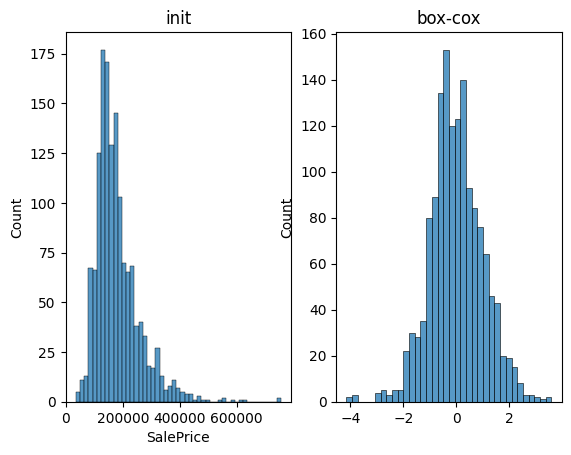

In [24]:
from sklearn.preprocessing import PowerTransformer
f, (ax1, ax2, ) = plt.subplots(1, 2)

power_transformer = PowerTransformer(method="box-cox").fit(y_train.values.reshape(-1,1))
y_train_tr = pd.Series(
    power_transformer.transform(y_train.values.reshape(-1,1)).ravel(),
    index=y_train.index,
)

sns.histplot(y_train, ax=ax1)
sns.histplot(
    y_train_tr,
    ax=ax2
)
ax1.set_title("init")
ax2.set_title("box-cox")

## Prep Pipeline

In [25]:
cat = X_train.select_dtypes(include="object")

quality_order = ["Po", "Fa", "TA", "Gd", "Ex"]
quality_cols = [
    "ExterQual", "ExterCond", "BsmtQual", 
    "BsmtCond", "KitchenQual", "FireplaceQu",
    "GarageQual", "GarageCond", "PoolQC", "Fence",
    "HeatingQC",
]

ordinal_cols = {}
for qual_col in quality_cols:
    ordinal_cols[qual_col] = quality_order
    
ordinal_cols["Utilities"] = [
    "ELO", "NoSeWa", "NoSewr", "AllPub"
]
ordinal_cols["BsmtExposure"] = [
    "No", "Mn", "Av", "Gd"
]

# less obvious
for col in ["BsmtFinType1", "BsmtFinType2"]:
    ordinal_cols[col] = [
        "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"
    ]
 
ordinal_cols["GarageFinish"] = [
    "Unf", "RFn", "Fin"
]

# ordinal_cols["Neighborhood"] = [
    
# ]

# ordinal_cols["Neighborhood"] = [
#     "Unf", "RFn", "Fin"
# ]


onehot_cols = list(np.setdiff1d(cat_cols, list(ordinal_cols.keys())))
num_cols = list(num_cols)

print("OH (orderless) cat cols: \n", onehot_cols, '\n')
print("Ordinal cols: \n", np.array(list(ordinal_cols.keys())), '\n')
print("Num cols: \n", np.array(num_cols))
assert len(ordinal_cols.keys()) + len(onehot_cols) + len(num_cols) == X_train.shape[1]

num_cols_selector = "|".join(["\w*" + col + "$" for col in num_cols])
ord_cols_selector = "|".join(["\w*" + col + "$" for col in list(ordinal_cols.keys())])
onehot_cols_selector = "|".join(["\w*" + col + "$" for col in onehot_cols])
print(onehot_cols_selector)

OH (orderless) cat cols: 
 ['Alley', 'BedroomAbvGr', 'BldgType', 'BsmtFullBath', 'BsmtHalfBath', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageCars', 'GarageType', 'GarageYrBlt', 'HalfBath', 'Heating', 'HouseStyle', 'KitchenAbvGr', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'YearBuilt', 'YearRemodAdd', 'YrSold'] 

Ordinal cols: 
 ['ExterQual' 'ExterCond' 'BsmtQual' 'BsmtCond' 'KitchenQual' 'FireplaceQu'
 'GarageQual' 'GarageCond' 'PoolQC' 'Fence' 'HeatingQC' 'Utilities'
 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'GarageFinish'] 

Num cols: 
 ['1stFlrSF' '2ndFlrSF' '3SsnPorch' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 'EnclosedPorch' 'GarageArea' 'GrLivArea' 'LotArea' 'LotFrontage'
 'LowQualFinSF' 'MasVnrArea' 'MiscVal' '

In [26]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.covariance import EllipticEnvelope

class EllipticTargetOutliersDropper(
    BaseEstimator, 
    TransformerMixin
):
    def __init__(
        self, 
        store_precision=True,
        assume_centered=False,
        support_fraction=None,
        contamination=0.1,
        random_state=None,
    ):
        self.outliers_idx = []
        self.env = EllipticEnvelope(
            contamination=contamination,
            store_precision=store_precision,
            assume_centered=assume_centered,
            support_fraction=support_fraction,
            random_state=random_state
        )

    def fit(self, X: pd.DataFrame, y):
        self.env.fit(y.reshape(-1,1))
        pred = self.env.predict(y.reshape(-1, 1))
        self.outliers_idx = X.index[np.argwhere(pred == -1).flatten()]
        return self

    def transform(self, X: pd.DataFrame, y):
        print(X.shape)
        print(args, kwargs)
        assert isinstance(X, pd.DataFrame)
        return X.drop(self.outliers_idx, errors="ignore")
    
    def get_feature_names_out(self, names_in):
        return names_in
    
    # def fit_transform(self, X, y=None, **fit_params):
    #     """
    #     Copy of TransformerMixing method, but passing y aswell.
    #     Issue: https://stackoverflow.com/questions/62819600/detect-and-remove-outliers-as-step-of-a-pipeline
    #     """
    #     if y is None:
    #             return self.fit(X, **fit_params).transform(X, y)
    #         else:
    #             return self.fit(X, y, **fit_params).transform(X, y)
    
    def __getattr__(self, attr):
        return getattr(self.env, attr)
 
def TargetRobustCovarianceSampler(X, y, contamination=0.1):
    env = EllipticEnvelope(contamination=contamination)
    env.fit(y.values.reshape(-1,1))
    pred = env.predict(y.values.reshape(-1,1))
    inliers_idx = X.index[np.argwhere(pred == 1).flatten()]

    return X.loc[inliers_idx], y.loc[inliers_idx]

In [27]:
# X, y = TargetRobustCovarianceSampler(X_train, y_train_tr)
from sklearn.linear_model import ElasticNet
import sklearn
# prep_pipeline[:1].fit_transform(X_train, y_train_tr)
# prep_pipeline[:1].fit_resample(X_train, y_train_tr)

# WORKS

# doesn't work
# p2 = make_pipeline(prep_pipeline, ElasticNet()).fit(X_train, y_train_tr)
# p2[:-1].fit_transform(X_train, y_train_tr)
# num_pipeline.fit_transform(X_train[num_cols], y_train_tr)

In [28]:
num_cols

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'EnclosedPorch',
 'GarageArea',
 'GrLivArea',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF']

In [29]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(
        self, 
        add_qual_area_int=True, 
        add_total_area=True, 
        add_fflr_total_ratio=True,
        add_fflr_lot_ratio=True,
        add_area_per_room=True,
        add_condition_qual_int=True,
        add_nbhood_qual_int=True,
        add_nbhood_total_area_int=True,
        add_central_air_qual_int=True,
        add_central_air_total_area_int=True,
        add_basement_liv_area_int=True,
    ):
        self.add_qual_area_int = add_qual_area_int
        self.add_total_area = add_total_area
        self.add_fflr_lot_ratio = add_fflr_lot_ratio
        self.add_fflr_total_ratio = add_fflr_total_ratio
        self.add_area_per_room = add_area_per_room
        self.add_condition_qual_int= add_condition_qual_int
        self.add_nbhood_qual_int = add_nbhood_qual_int
        self.add_nbhood_total_area_int = add_nbhood_total_area_int
        self.add_central_air_qual_int = add_central_air_qual_int
        self.add_central_air_total_area_int = add_central_air_total_area_int
        self.add_basement_liv_area_int = add_basement_liv_area_int
        
        self.nbhoods_names = []
        self.central_air_col_name = None
        
    def fit(self, X, y=None):
        return self  
    
    def get_col_(X: pd.DataFrame, col) -> pd.Series:
        return X[make_column_selector(col)].squeeze()
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        init_index = X.index
        init_cols = X.columns
        
        total_area = X[make_column_selector("TotalBsmtSF")].values + X[make_column_selector("GrLivArea")]
        qual_area_int = X[make_column_selector("OverallQual")].values + total_area
        fflr_total_ratio = X[make_column_selector("1stFlrSF")].values / X[make_column_selector("GrLivArea")]
        fflr_lot_ratio = X[make_column_selector("1stFlrSF")].values / X[make_column_selector("LotArea")]
        area_per_room = X[make_column_selector("GrLivArea")].values / X[make_column_selector("TotRmsAbvGrd")]
        condition_qual_int = X[make_column_selector("OverallCond")].values * X[make_column_selector("OverallQual")]
        basement_liv_area_int = X[make_column_selector("GrLivArea")].values * X[make_column_selector("TotalBsmtSF")]
        
        nbhoods = X[make_column_selector("Neighborhood")]
        self.nbhoods_names = np.array(nbhoods.columns).astype(str)
        nbhood_qual_int = nbhoods.values * X[make_column_selector("OverallQual")].values
        nbhood_total_area_int = nbhoods.values * total_area.values
        
        central_air = X[make_column_selector("CentralAir")]
        self.central_air_col_name = central_air.columns[0]
        central_air_qual_int = central_air.values * X[make_column_selector("OverallQual")]
        central_air_total_area_int = central_air.values * total_area
        
        if self.add_qual_area_int:
            X = np.c_[X, qual_area_int]
        if self.add_total_area:
            X = np.c_[X, total_area]
        if self.add_fflr_total_ratio:
            X = np.c_[X, fflr_total_ratio]
        if self.add_fflr_lot_ratio:
            X = np.c_[X, fflr_lot_ratio]
        if self.add_area_per_room:
            X = np.c_[X, area_per_room]
        if self.add_condition_qual_int:
            X = np.c_[X, condition_qual_int]
        if self.add_nbhood_qual_int:
            X = np.c_[X, nbhood_qual_int]
        if self.add_nbhood_total_area_int:
            X = np.c_[X, nbhood_total_area_int]
        if self.add_central_air_qual_int:
            X = np.c_[X, central_air_qual_int]
        if self.add_central_air_total_area_int:
            X = np.c_[X, central_air_total_area_int]
        if self.add_basement_liv_area_int:
            X = np.c_[X, basement_liv_area_int]
            
        return pd.DataFrame(
            X, 
            columns=self.get_feature_names_out(init_cols), 
            index=init_index
        )
                                                                                                      
    def get_feature_names_out(self, names, *args, **kwargs):
        if self.add_qual_area_int:
            names = np.append(names, "OverallQual TotArea")
        if self.add_total_area:
            names = np.append(names, "TotArea")
        if self.add_fflr_total_ratio:
            names = np.append(names, "1stFlr/GrLivArea")
        if self.add_fflr_lot_ratio:
            names = np.append(names, "1stFlr/LotArea")
        if self.add_area_per_room:
            names = np.append(names, "PerRoomArea")
        if self.add_condition_qual_int:
            names = np.append(names, "OverallCond OverallQual")
        if self.add_nbhood_qual_int:
            int_names = np.core.defchararray.add(self.nbhoods_names, np.array([" OverallQual"]))
            names = np.append(names, int_names)
        if self.add_nbhood_total_area_int:
            int_names = np.core.defchararray.add(self.nbhoods_names, np.array([" TotArea"]))
            names = np.append(names, int_names)
        if self.add_central_air_qual_int:
            names = np.append(names, self.central_air_col_name + " OverallQual")
        if self.add_central_air_total_area_int:
            names = np.append(names, self.central_air_col_name + " TotArea")
        if self.add_basement_liv_area_int:
            names = np.append(names, "TotalBsmtSF GrLivArea")
        return names

engineered_features = [
    "TotArea", "OverallQual TotArea", "1stFlr/GrLivArea", 
    "1stFlr/LotArea", "PerRoomArea", "OverallCond OverallQual",
]
engineered_features_col_selector = "|".join(["\w*" + feat + "$" for feat in engineered_features])

In [30]:
# df = prep_pipeline[:-1].fit_transform(X_train)
# df.iloc[:, -10:]
# pd.DataFrame(df, columns = prep_pipeline[:-1].get_feature_names_out())

There are problems with the following pipeline which I surmise are intrinsic limitations of sklearn's pipeline system:
- Strictly speaking, I need to scale after including interactions. However, I need to scale only numeric variables. Problem: there is no way to keep track of variables **after** the very first `ColumnTransformer`. There is no way to combine `ColumnTransformer`s.
- For the same reason, I can't choose **which** interactions to include. I wouldn't want interaction of ordinal variables with numeric ones -- this is nonsense.

Things I've tried:
- keeping track of column transformations inside the pipeline with `get_feature_names_out()` and simple function transformers to convert to `pd.DataFrame`. Problem: the pipeline then depends on the particular dataset; it fails if the number of features, of features themselves change, which is the case when using pipelines with `OneHotEncoder` with cross-validation.

In [31]:
# from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_selector
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


orde = OrdinalEncoder(
    categories=list(ordinal_cols.values()),
    handle_unknown="use_encoded_value",
    unknown_value=-1, 
)
ohe = OneHotEncoder(
    handle_unknown="ignore",
    drop="first", sparse=False,
)

def to_type_str(x): return x.astype(str)
def identity_2(x, y): return y

onehot_cat_pipeline = Pipeline([
    ("attrib", CategoryShrinker()),
    ("astype", FunctionTransformer(
        to_type_str,
        feature_names_out=identity_2)
    ),
    ("onehot", ohe)
])

num_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
])

ordinal_cat_pipeline = Pipeline([
    ("ordinal", orde),
    ("imp", SimpleImputer(strategy="median")),
])

prep_pipeline = Pipeline([
    ("outliers", FunctionSampler(
        func=TargetRobustCovarianceSampler, 
        validate=False, 
        kw_args={"contamination": 0.1}
    )),
    ("preprocess", PandasColumnTransformer([
        ("num", num_pipeline, np.array(num_cols)),
        ("ord", ordinal_cat_pipeline, np.array(list(ordinal_cols.keys()))),
        ("hot", onehot_cat_pipeline, np.array(onehot_cols)),
    ])),
    ("fe", CombinedAttributesAdder()), 
    ("scale", make_column_transformer(
        (StandardScaler(), make_column_selector(
            num_cols_selector + "|" +
            ord_cols_selector + "|" +
            engineered_features_col_selector
        ))
    , remainder="passthrough", verbose_feature_names_out=False)),
    ("duplicates", VarianceThreshold()),
    ("select", "passthrough"),
    ("mod", GradientBoostingRegressor())
])

In [610]:
prep_pipeline

Pipeline(steps=[('outliers',
                 FunctionSampler(func=<function TargetRobustCovarianceSampler at 0x0000028533C4CEE0>,
                                 kw_args={'contamination': 0.0001},
                                 validate=False)),
                ('preprocess',
                 PandasColumnTransformer(transformers=[('num',
                                                        Pipeline(steps=[('imp',
                                                                         SimpleImputer(strategy='median'))]),
                                                        array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtU...
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000285341F6A70>)],
                                   verbose_feature_names_out=False)),
                ('duplicates', VarianceThreshold()),
                ('select',
                 RFE(estimator=GradientBoostingRegressor(max_depth=6,
                                                         max_features='sqrt',
                                                         n_estimators=300,
                                                         random_state=42),
                     n_features_to_select=80)),
                ('mod', LinearRegression())])

## Training

In [33]:
prep_pipeline.get_params()

{'memory': None,
 'steps': [('outliers',
   FunctionSampler(func=<function TargetRobustCovarianceSampler at 0x0000028533C4CEE0>,
                   kw_args={'contamination': 0.1}, validate=False)),
  ('preprocess',
   PandasColumnTransformer(transformers=[('num',
                                          Pipeline(steps=[('imp',
                                                           SimpleImputer(strategy='median'))]),
                                          array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
          'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GrLivArea', 'LotArea',
          'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal',
          'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
          'ScreenPorc...
          'Foundation', 'FullBath', 'Functional', 'GarageCars', 'GarageType',
          'GarageYrBlt', 'HalfBath', 'Heating', 'HouseStyle', 'KitchenAbvGr',
          'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSu

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

main_params = { "outliers__kw_args": [
    {"contamination": val} for val in [1e-4, 1e-3, 1e-2, 1e-1]
] }
boost_params = [
    {
        "mod": [GradientBoostingRegressor()],  
        "mod__max_depth": [2, 3, 6, 10],
        "mod__learning_rate": [0.01],
        "mod__n_estimators": [1000],
        "mod__subsample": [0.5, 1],
        "mod__max_features": ["sqrt", 1],
        **main_params
    }, 
]
forest_params = [
    {
        "mod": [RandomForestRegressor()],  
        "mod__max_depth": [5, 10, None],
        "mod__min_samples_split": [5, 10, 20, 50],
        "mod__n_estimators": [1000],
        "mod__max_features": ["sqrt", 1],
        "mod__random_state": [42],
        **main_params
    },
]

tree_params = {
    "mod": [DecisionTreeRegressor()],  
    "mod__max_depth": [7, 10, 12, 15],
    "mod__min_samples_split": [40, 50, 60],
    **main_params
}

lightgbm_params = {
    "mod": [LGBMRegressor()],
    "mod__max_depth": [5, 10, -1],
    "mod__learning_rate": [0.01, 0.1],
    "mod__learning_rate": [0.01, 0.1],
    "mod__subsample": [0.5, 1],
    "mod__random_state": [42],
    "mod__n_estimators": [1000],
    **main_params
}

xgboost_params = {
    "mod": [XGBRegressor()],
    "mod__max_depth": [5, 10, None],
    "mod__learning_rate": [0.01, 0.1],
    "mod__learning_rate": [0.01, 0.1],
    "mod__subsample": [0.5, 1],
    "mod__random_state": [42],
    "mod__n_estimators": [1000],
    **main_params
}

start = len(num_cols) + len(ordinal_cols.keys())
catboost_params = {
    # turn off OHE -- catergories are handled natively
    "mod": [CatBoostRegressor()],
    "preprocess": [PandasColumnTransformer([
        ("num", num_pipeline, np.array(num_cols)),
        ("ord", ordinal_cat_pipeline, np.array(list(ordinal_cols.keys()))),
        ("hot", FunctionTransformer(to_type_str, feature_names_out=identity_2), np.array(onehot_cols)),
    ])],
    "fe": ["passthrough"],
    "duplicates": ["passthrough"],
    "mod__max_depth": [5, 10, None],
    "mod__cat_features": [np.arange(start, start + len(onehot_cols))], 
    "mod__subsample": [1, 0.5],
    "mod__learning_rate": [0.1, 0.01],
    "mod__iterations": [1000],
    **main_params
}


boost_params

[{'mod': [GradientBoostingRegressor()],
  'mod__max_depth': [2, 3, 6, 10],
  'mod__learning_rate': [0.01],
  'mod__n_estimators': [1000],
  'mod__subsample': [0.5, 1],
  'mod__max_features': ['sqrt', 1],
  'outliers__kw_args': [{'contamination': 0.0001},
   {'contamination': 0.001},
   {'contamination': 0.01},
   {'contamination': 0.1}]}]

In [35]:
X_train.iloc[:, np.arange(start, start + len(onehot_cols))]

,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [36]:
from joblib import dump, load
from sklearn.model_selection import RandomizedSearchCV

BOOST_GS_RES_FILE_NAME = "boost_gs.joblib"
FOREST_GS_RES_FILE_NAME = "forest_gs.joblib"
TREE_GS_RES_FILE_NAME = "tree_gs.joblib"
LIGHTGBM_GS_RES_FILE_NAME = "lightgbm_gs.joblib"
XGB_GS_RES_FILE_NAME = "xgb_gs.joblib"
CATBOOST_GS_RES_FILE_NAME = "catboost_gs.joblib"

gs_params = {
    "random_state": 42,
    "n_iter": 50,
    "cv": 5,
    "verbose": 2,
    "error_score": 'raise',
    "scoring": ["neg_mean_squared_error", "r2", "neg_root_mean_squared_error"],
    "refit": "neg_root_mean_squared_error",
    "n_jobs": 4,
}

boost_gs = CachedRandomizedSearchCV(
    prep_pipeline, boost_params, 
    cache_file_name=BOOST_GS_RES_FILE_NAME,
    **gs_params
)
forest_gs = CachedRandomizedSearchCV(
    prep_pipeline, forest_params, 
    cache_file_name=FOREST_GS_RES_FILE_NAME,
    **gs_params
)

tree_gs = CachedRandomizedSearchCV(
    prep_pipeline, tree_params,
    cache_file_name=TREE_GS_RES_FILE_NAME,
    **gs_params
)

lightgbm_gs = CachedRandomizedSearchCV(
    prep_pipeline, lightgbm_params,
    cache_file_name=LIGHTGBM_GS_RES_FILE_NAME,
    **gs_params
)

xgboost_gs = CachedRandomizedSearchCV(
    prep_pipeline, xgboost_params,
    cache_file_name=XGB_GS_RES_FILE_NAME,
    **gs_params
)

catboost_gs = CachedRandomizedSearchCV(
    prep_pipeline, catboost_params,
    cache_file_name=CATBOOST_GS_RES_FILE_NAME,
    **{ **gs_params, 'n_iter': 1, 'n_jobs': 2}
)

for gs in [boost_gs, forest_gs, tree_gs, lightgbm_gs, xgboost_gs, catboost_gs]:
    if not hasattr(gs, "best_params_"):
        gs.fit(X_train, y_train_tr)

In [37]:
boost_gs.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_outliers__kw_args', 'param_mod__subsample', 'param_mod__n_estimators', 'param_mod__max_features', 'param_mod__max_depth', 'param_mod__learning_rate', 'param_mod', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [38]:
for gs in [boost_gs,forest_gs, tree_gs, lightgbm_gs, xgboost_gs, catboost_gs]:
    print(gs.best_params_, gs.best_score_)

{'outliers__kw_args': {'contamination': 0.0001}, 'mod__subsample': 0.5, 'mod__n_estimators': 1000, 'mod__max_features': 'sqrt', 'mod__max_depth': 6, 'mod__learning_rate': 0.01, 'mod': GradientBoostingRegressor(learning_rate=0.01, max_depth=6, max_features='sqrt',
                          n_estimators=1000, subsample=0.5)} 0.9066652915561668
{'outliers__kw_args': {'contamination': 0.0001}, 'mod__n_estimators': 1000, 'mod__min_samples_split': 5, 'mod__max_features': 'sqrt', 'mod__max_depth': None, 'mod': RandomForestRegressor(max_features='sqrt', min_samples_split=5,
                      n_estimators=1000)} 0.8812635933848065
{'outliers__kw_args': {'contamination': 0.0001}, 'mod__min_samples_split': 40, 'mod__max_depth': 10, 'mod': DecisionTreeRegressor(max_depth=10, min_samples_split=40)} 0.7915258402036984
{'outliers__kw_args': {'contamination': 0.001}, 'mod__subsample': 0.5, 'mod__random_state': 42, 'mod__n_estimators': 1000, 'mod__max_depth': 5, 'mod__learning_rate': 0.01, 'mod': L

In [39]:
boost_gs.score(X_train, y_train_tr)

0.9840868144138433

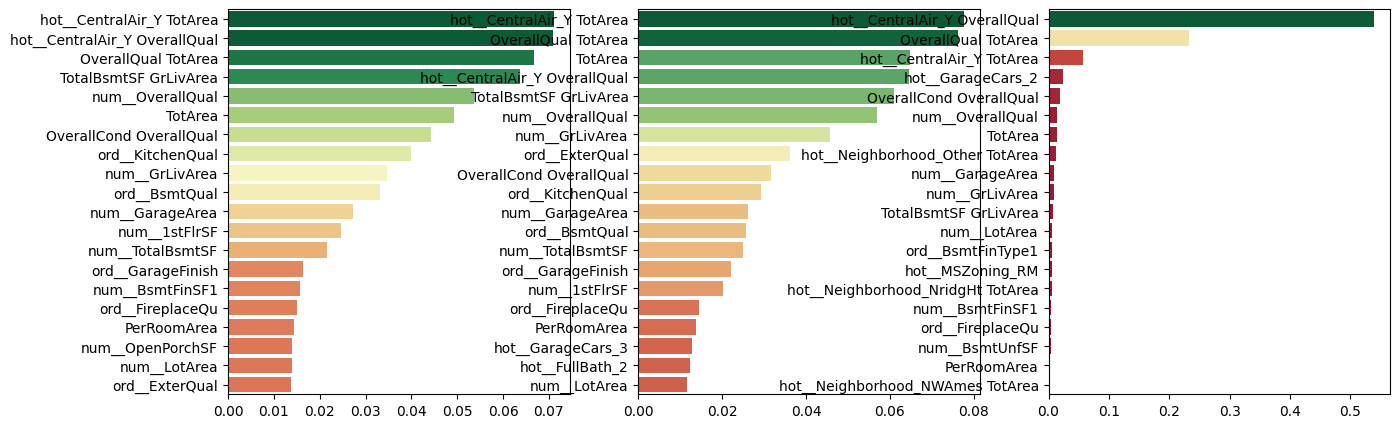

In [40]:
f, axs = plt.subplots(1, 3, figsize=(15,5))
axs = axs.ravel()

for ax, gs in zip(axs, [boost_gs, forest_gs, tree_gs]):
    tree = gs.best_estimator_[-1]
    importances = pd.Series(
        tree.feature_importances_,
        gs.best_estimator_[:-1].get_feature_names_out()
    ).sort_values(ascending=False)
                  
    norm = plt.Normalize(0, importances.max())
    colors = plt.cm.RdYlGn(importances.apply(norm))
    sns.barplot(x=importances[:20], y=importances.index[:20], ax=ax, palette=colors)

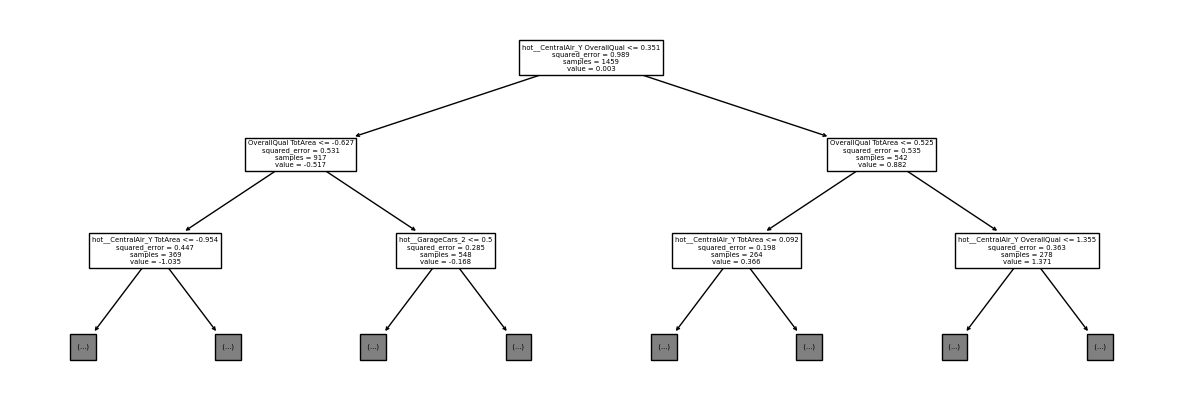

In [41]:
from sklearn.tree import plot_tree
f, ax = plt.subplots(1, 1, figsize=(15, 5))
_ = plot_tree(
    tree,
    max_depth=2, ax=ax,
    feature_names=tree_gs.best_estimator_[:-1].get_feature_names_out()
)

## Linear
Normally, I wouldn't go for OLS in this problem, but for ridge straight away. </br> 
Reason: not only do I expect multicollinearity, but also I loose nothing, if alpha=0 is included in grid params. </br>
However, since I'm going to run some statistical analysis on the results, and since the current state of `statsmodels` doesn't provide anything but fitting capabilities when it comes to regularized models. </br>
A better idea would be to proceed in `R` at this point... </br>
At any rate, the difference between ridge and ols fits is not that significant.

In [357]:
from sklearn.linear_model import Ridge, LassoCV

elastic_params = {
    "mod": [ElasticNet()],
    "mod__alpha": np.linspace(0, 1, num=100),
    "mod__l1_ratio": np.linspace(0, 1, num=100),
    **main_params,
}

ridge_params = {
    # expect multicollinearity
    "mod": [Ridge()],
    "mod__alpha": [0.96],
    "select": [RFE(GradientBoostingRegressor(
        n_estimators=300,
        max_features="sqrt",
        max_depth=6,
        random_state=42,
    )), 
               # RFE(LassoCV(tol=0.01))
    ],
    "select__n_features_to_select": [130],
    'outliers__kw_args': [{'contamination': 0.0001}]
}
ols_params = {
    # expect multicollinearity
    "mod": [LinearRegression()],
    "select": [RFE(GradientBoostingRegressor(
        n_estimators=300,
        max_features="sqrt",
        max_depth=6,
        random_state=42,
    )),],
    "select__n_features_to_select": [10, 20, 30, 50, 70, 80, 90, 100, 110, 130],
    'outliers__kw_args': [{'contamination': 0.0001}]
}
from sklearn.model_selection import ParameterGrid

In [382]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, make_scorer


def ols_neg_aic_scorer(estimator, X, y, intercept_included=False):
    # p = np.linalg.matrix_rank(estimator[:-1].transform(X))
    p = estimator[-1].rank_
    if not intercept_included:
        p += 1
 
    y_pred = estimator.predict(X)
    ssr = ((y - y_pred)**2).sum()
    nobs = len(y)
    nobs2 = nobs / 2.0
    llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr/ nobs) - nobs2
    aic = -2*llf + 2 * p
    return -aic

def r2_adj_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    r2 = r2_score(y, y_pred)
    nobs = len(y)
    # intercept
    p = estimator[-1].rank_
    p += 1
    df_resid = nobs - p
    r2adj = 1 - (nobs-1)/df_resid * (1-r2)
    return r2adj


ELASTIC_GS_FILE_NAME = "elastic_gs.joblib"
RIDGE_GS_FILE_NAME = "ridge_gs.joblib"
OLS_GS_FILE_NAME = "ols_gs.joblib"

elastic_gs = CachedRandomizedSearchCV(
    prep_pipeline, elastic_params,
    **gs_params,
    cache_file_name=ELASTIC_GS_FILE_NAME
)

ridge_gs = CachedRandomizedSearchCV(
    prep_pipeline, ridge_params,
    **gs_params,
    cache_file_name=RIDGE_GS_FILE_NAME
)

ols_gs = CachedRandomizedSearchCV(
    prep_pipeline, ols_params,
    cache_file_name=OLS_GS_FILE_NAME,
    **{**gs_params,
       "refit": ols_aic_scorer,
       'scoring': {
           "r2": make_scorer(r2_score),
           "aic": ols_neg_aic_scorer,
           "r2adj": r2_adj_scorer
        },
       "refit": "aic", 
    }
)

for gs in [ridge_gs, elastic_gs, ols_gs]:
    if not hasattr(gs, "best_params_"):
        gs.fit(X_train, y_train_tr)

C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 10 is smaller than n_iter=50. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [605]:
from sklearn.metrics import r2_score

for gs in [elastic_gs, ridge_gs]:
    print(gs.best_params_, gs.cv_results_["mean_test_r2"].max(), r2_score(y_train_tr, gs.predict(X_train)))

chosen_ols_idx = ols_gs.cv_results_["mean_test_aic"].argmax()
print(
    ols_gs.best_params_, ols_gs.cv_results_["mean_test_r2"].max(), 
    ols_gs.cv_results_["mean_test_r2"][chosen_ols_idx]
)
#we've lost only 3% explainability by removing 110 predictors!

{'outliers__kw_args': {'contamination': 0.0001}, 'mod__l1_ratio': 0.15151515151515152, 'mod__alpha': 0.020202020202020204, 'mod': ElasticNet(alpha=0.020202020202020204, l1_ratio=0.15151515151515152)} 0.9000381848843034 0.9168065870321681
{'mod': Ridge(alpha=0.96), 'mod__alpha': 0.96, 'outliers__kw_args': {'contamination': 0.0001}, 'select': RFE(estimator=GradientBoostingRegressor(max_depth=6, max_features='sqrt',
                                        n_estimators=300),
    n_features_to_select=130), 'select__n_features_to_select': 130} 0.9075544713790847 0.9309792768207659


Text(0, 0.5, 'metric')

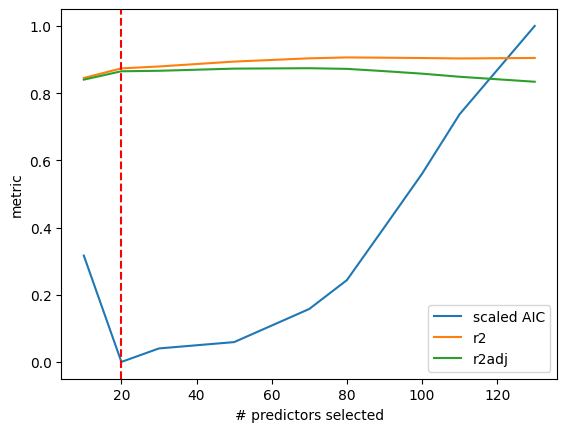

In [406]:
from sklearn.preprocessing import MinMaxScaler
ix = ols_gs.cv_results_["param_select__n_features_to_select"]
scaled_aic = MinMaxScaler().fit_transform(
    (-ols_gs.cv_results_["mean_test_aic"]).reshape(-1, 1)
).ravel()

sns.lineplot(x=ix, y=scaled_aic, label="scaled AIC")
sns.lineplot(x=ix, y=ols_gs.cv_results_["mean_test_r2"], label="r2")
sns.lineplot(x=ix, y=ols_gs.cv_results_["mean_test_r2adj"], label="r2adj")
ax = plt.gca()
ax.axvline(20, ls='--', color="red")
ax.set_xlabel("# predictors selected")
ax.set_ylabel("metric")

70

## Diagnostics and interpretation

### Singularity

In [465]:
r2_chosen_idx = ols_gs.cv_results_["mean_test_r2"].argmax()
best_r2_params = ols_gs.cv_results_["params"][r2_chosen_idx]
best_r2_est = ols_gs.estimator
best_r2_est.set_params(**best_r2_params)
best_r2_est

Pipeline(steps=[('outliers',
                 FunctionSampler(func=<function TargetRobustCovarianceSampler at 0x0000028533C4CEE0>,
                                 kw_args={'contamination': 0.0001},
                                 validate=False)),
                ('preprocess',
                 PandasColumnTransformer(transformers=[('num',
                                                        Pipeline(steps=[('imp',
                                                                         SimpleImputer(strategy='median'))]),
                                                        array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtU...
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000285341F6A70>)],
                                   verbose_feature_names_out=False)),
                ('duplicates', VarianceThreshold()),
                ('select',
                 RFE(estimator=GradientBoostingRegressor(max_depth=6,
                                                         max_features='sqrt',
                                                         n_estimators=300,
                                                         random_state=42),
                     n_features_to_select=80)),
                ('mod', LinearRegression())])

In [460]:
r2adj_chosen_idx = ols_gs.cv_results_["mean_test_r2adj"].argmax()
best_r2adj_params = ols_gs.cv_results_["params"][r2adj_chosen_idx]
best_r2adj_est = ols_gs.estimator
best_r2adj_est.set_params(**best_r2adj_params)
best_r2adj_est

Pipeline(steps=[('outliers',
                 FunctionSampler(func=<function TargetRobustCovarianceSampler at 0x0000028533C4CEE0>,
                                 kw_args={'contamination': 0.0001},
                                 validate=False)),
                ('preprocess',
                 PandasColumnTransformer(transformers=[('num',
                                                        Pipeline(steps=[('imp',
                                                                         SimpleImputer(strategy='median'))]),
                                                        array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtU...
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000285341F6A70>)],
                                   verbose_feature_names_out=False)),
                ('duplicates', VarianceThreshold()),
                ('select',
                 RFE(estimator=GradientBoostingRegressor(max_depth=6,
                                                         max_features='sqrt',
                                                         n_estimators=300,
                                                         random_state=42),
                     n_features_to_select=70)),
                ('mod', LinearRegression())])

In [461]:
# ols_gs.best_estimator_[:-1]

Pipeline(steps=[('outliers',
                 FunctionSampler(func=<function TargetRobustCovarianceSampler at 0x0000028533C4CEE0>,
                                 kw_args={'contamination': 0.0001},
                                 validate=False)),
                ('preprocess',
                 PandasColumnTransformer(transformers=[('num',
                                                        Pipeline(steps=[('imp',
                                                                         SimpleImputer(strategy='median'))]),
                                                        array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtU...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002855C8D0FA0>)],
                                   verbose_feature_names_out=False)),
                ('duplicates', VarianceThreshold()),
                ('select',
                 RFE(estimator=GradientBoostingRegressor(max_depth=6,
                                                         max_features='sqrt',
                                                         n_estimators=300,
                                                         random_state=42),
                     n_features_to_select=20))])

In [439]:
# X_train_resamp, y_train_tr_resamp = ols_gs.best_estimator_[0].fit_resample(X_train, y_train_tr)
# X_tr = pd.DataFrame(
#     ols_gs.best_estimator_[1:-1].fit_transform(X_train_resamp, y_train_tr_resamp),
#     columns=ols_gs.best_estimator_[1:-1].get_feature_names_out(),
#     index=X_train_resamp.index
# )


In [468]:
X_tr = pd.DataFrame(
    best_r2adj_est[1:-1].fit_transform(X_train_resamp, y_train_tr_resamp),
    columns=best_r2adj_est[1:-1].get_feature_names_out(),
    index=X_train_resamp.index
)

In [472]:
y_tr = y_train_tr_resamp
y_tr.shape, X_tr.shape

((1459,), (1459, 80))

In [473]:
lmod = sm.OLS(y_tr, add_constant(X_tr)).fit(method="pinv")
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     215.0
Date:                Sat, 24 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:22:12   Log-Likelihood:                -191.60
No. Observations:                1459   AIC:                             539.2
Df Residuals:                    1381   BIC:                             951.5
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.8857      0.187     -4.732      0.000      -1.253      -0.519
num__1stFlrSF                             0.2053      0.074      2.761      0.006       0.059       0.351
num__2ndFlrSF                             0.2357      0.074      3.171      0.002       0.090       0.381
num__BsmtFinSF1                           0.1215      0.014      8.447      0.000       0.093       0.150
num__BsmtFinSF2                           0.0274      0.009      3.152      0.002       0.010       0.044
num__BsmtUnfSF                            0.0374      0.013      2.949      0.003       0.013       0.062
num__EnclosedPorch                        0.0071      0.008      0.853      0.394      -0.009       0.024
num__GarageArea                           0.0094      0.017      0.537      0.591      -0.025       0.044
num__GrLivArea                           -0.0507      0.071     -0.715      0.474      -0.190       0.088
num__LotArea                              0.0255      0.009      2.713      0.007       0.007       0.044
num__LotFrontage                          0.0189      0.010      1.844      0.065      -0.001       0.039
num__MasVnrArea                           0.0050      0.009      0.538      0.591      -0.013       0.023
num__OpenPorchSF                          0.0167      0.009      1.909      0.056      -0.000       0.034
num__OverallCond                          0.1414      0.040      3.514      0.000       0.062       0.220
num__OverallQual                          0.2298      0.052      4.445      0.000       0.128       0.331
num__ScreenPorch                          0.0295      0.008      3.718      0.000       0.014       0.045
num__TotRmsAbvGrd                         0.1495      0.055      2.710      0.007       0.041       0.258
num__TotalBsmtSF                          0.1741      0.025      6.953      0.000       0.125       0.223
num__WoodDeckSF                           0.0258      0.009      3.034      0.002       0.009       0.043
ord__ExterQual                            0.0308      0.013      2.284      0.023       0.004       0.057
ord__ExterCond                           -0.0086      0.009     -1.007      0.314      -0.025       0.008
ord__BsmtQual                             0.0118      0.014      0.845      0.399      -0.016       0.039
ord__KitchenQual                          0.0365      0.012      3.017      0.003       0.013       0.060
ord__FireplaceQu                          0.0305      0.010      3.109      0.002       0.011       0.050
ord__GarageQual                           0.0699      0.030      2.368      0.018       0.012       0.128
ord__GarageCond                           0.0328      0.030      1.097      0.273      -0.026       0.092
ord__Heat

In [475]:
np.linalg.matrix_rank(X_tr), X_tr.shape[1]

(77, 80)

In [476]:
from scipy.linalg import qr

Q, R, P = qr(X_tr, mode="economic", pivoting=True)
inv = P.argsort() # reversed order (necessary here)
good_columns = (np.abs(np.diag(R)) > 1e-10)[inv]
print("lin dep cols: ", list(X_tr.columns[np.invert(good_columns)]))

lin dep cols:  ['num__BsmtFinSF1', 'OverallQual TotArea', 'TotArea']


In [477]:
X_tr_fullr = X_tr.loc[:, good_columns]
np.linalg.matrix_rank(X_tr_fullr), X_tr_fullr.shape[1]

(77, 77)

In [478]:
lmod = sm.OLS(y_tr, add_constant(X_tr_fullr)).fit(method="pinv")
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     215.0
Date:                Sat, 24 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:22:55   Log-Likelihood:                -191.60
No. Observations:                1459   AIC:                             539.2
Df Residuals:                    1381   BIC:                             951.5
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.8857      0.187     -4.732      0.000      -1.253      -0.519
num__1stFlrSF                             0.2053      0.074      2.761      0.006       0.059       0.351
num__2ndFlrSF                             0.2357      0.074      3.171      0.002       0.090       0.381
num__BsmtFinSF2                          -0.0156      0.008     -1.843      0.066      -0.032       0.001
num__BsmtUnfSF                           -0.0803      0.014     -5.727      0.000      -0.108      -0.053
num__EnclosedPorch                        0.0071      0.008      0.853      0.394      -0.009       0.024
num__GarageArea                           0.0094      0.017      0.537      0.591      -0.025       0.044
num__GrLivArea                            0.0266      0.116      0.229      0.819      -0.201       0.254
num__LotArea                              0.0255      0.009      2.713      0.007       0.007       0.044
num__LotFrontage                          0.0189      0.010      1.844      0.065      -0.001       0.039
num__MasVnrArea                           0.0050      0.009      0.538      0.591      -0.013       0.023
num__OpenPorchSF                          0.0167      0.009      1.909      0.056      -0.000       0.034
num__OverallCond                          0.1414      0.040      3.514      0.000       0.062       0.220
num__OverallQual                          0.2299      0.052      4.447      0.000       0.128       0.331
num__ScreenPorch                          0.0295      0.008      3.718      0.000       0.014       0.045
num__TotRmsAbvGrd                         0.1495      0.055      2.710      0.007       0.041       0.258
num__TotalBsmtSF                          0.3556      0.037      9.711      0.000       0.284       0.427
num__WoodDeckSF                           0.0258      0.009      3.034      0.002       0.009       0.043
ord__ExterQual                            0.0308      0.013      2.284      0.023       0.004       0.057
ord__ExterCond                           -0.0086      0.009     -1.007      0.314      -0.025       0.008
ord__BsmtQual                             0.0118      0.014      0.845      0.399      -0.016       0.039
ord__KitchenQual                          0.0365      0.012      3.017      0.003       0.013       0.060
ord__FireplaceQu                          0.0305      0.010      3.109      0.002       0.011       0.050
ord__GarageQual                           0.0699      0.030      2.368      0.018       0.012       0.128
ord__GarageCond                           0.0328      0.030      1.097      0.273      -0.026       0.092
ord__HeatingQC                            0.0422      0.010      4.239      0.000       0.023       0.062
ord__Bsmt

In [534]:
X_tr = X_tr_fullr

### Multicollinearity

In [535]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vifs(X: pd.DataFrame, add_constant=True):
    if add_constant:
        X = statsmodels.tools.add_constant(X)
    return pd.Series(
        [variance_inflation_factor(X, i) 
         for i in range(len(X.columns))],
        index=X.columns
    ).drop("const")

In [536]:
vifs = get_vifs(X_tr).sort_values(ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(vifs[:50])

num__GrLivArea                           244.507819
num__1stFlrSF                            100.237891
num__2ndFlrSF                            100.216147
hot__CentralAir_Y OverallQual             73.800418
OverallCond OverallQual                   61.601833
hot__Neighborhood_Crawfor OverallQual     58.206091
num__TotRmsAbvGrd                         55.186586
num__OverallQual                          48.471041
hot__Neighborhood_Crawfor                 45.115355
hot__CentralAir_Y TotArea                 44.325212
hot__Neighborhood_OldTown OverallQual     37.156821
hot__GarageCars_2                         35.513684
hot__Neighborhood_Other TotArea           34.303989
hot__Neighborhood_Other OverallQual       31.267884
hot__Neighborhood_OldTown                 30.770527
PerRoomArea                               30.454954
num__OverallCond                          29.351642
1stFlr/GrLivArea                          27.968829
hot__GarageCars_1                         27.497413
hot__Neighbo

In [538]:
X_tr_noncoll = X_tr.drop(columns=vifs[:5].index)
lmod3 = sm.OLS(y_tr, add_constant(X_tr_noncoll)).fit()
lmod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     226.4
Date:                Sat, 24 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:22:32   Log-Likelihood:                -204.46
No. Observations:                1459   AIC:                             554.9
Df Residuals:                    1386   BIC:                             940.8
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.8165      0.147     -5.543      0.000      -1.105      -0.528
num__BsmtFinSF2                          -0.0149      0.009     -1.749      0.081      -0.032       0.002
num__BsmtUnfSF                           -0.0787      0.014     -5.612      0.000      -0.106      -0.051
num__EnclosedPorch                        0.0084      0.008      0.996      0.319      -0.008       0.025
num__GarageArea                           0.0127      0.018      0.722      0.470      -0.022       0.047
num__LotArea                              0.0258      0.009      2.740      0.006       0.007       0.044
num__LotFrontage                          0.0167      0.010      1.617      0.106      -0.004       0.037
num__MasVnrArea                           0.0083      0.009      0.901      0.368      -0.010       0.026
num__OpenPorchSF                          0.0163      0.009      1.859      0.063      -0.001       0.034
num__OverallCond                          0.1085      0.010     11.179      0.000       0.089       0.127
num__OverallQual                          0.1815      0.019      9.490      0.000       0.144       0.219
num__ScreenPorch                          0.0277      0.008      3.470      0.001       0.012       0.043
num__TotRmsAbvGrd                         0.3275      0.021     15.642      0.000       0.286       0.369
num__TotalBsmtSF                          0.2931      0.030      9.759      0.000       0.234       0.352
num__WoodDeckSF                           0.0259      0.009      3.024      0.003       0.009       0.043
ord__ExterQual                            0.0263      0.013      1.952      0.051      -0.000       0.053
ord__ExterCond                           -0.0052      0.009     -0.613      0.540      -0.022       0.012
ord__BsmtQual                             0.0223      0.014      1.634      0.103      -0.004       0.049
ord__KitchenQual                          0.0363      0.012      2.977      0.003       0.012       0.060
ord__FireplaceQu                          0.0319      0.010      3.236      0.001       0.013       0.051
ord__GarageQual                           0.0611      0.029      2.081      0.038       0.004       0.119
ord__GarageCond                           0.0424      0.030      1.416      0.157      -0.016       0.101
ord__HeatingQC                            0.0436      0.010      4.365      0.000       0.024       0.063
ord__BsmtExposure                         0.0287      0.009      3.106      0.002       0.011       0.047
ord__BsmtFinType1                         0.0254      0.012      2.058      0.040       0.001       0.050
ord__GarageFinish                         0.0244      0.012      2.051      0.040       0.001       0.048
1stFlr/Gr

C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


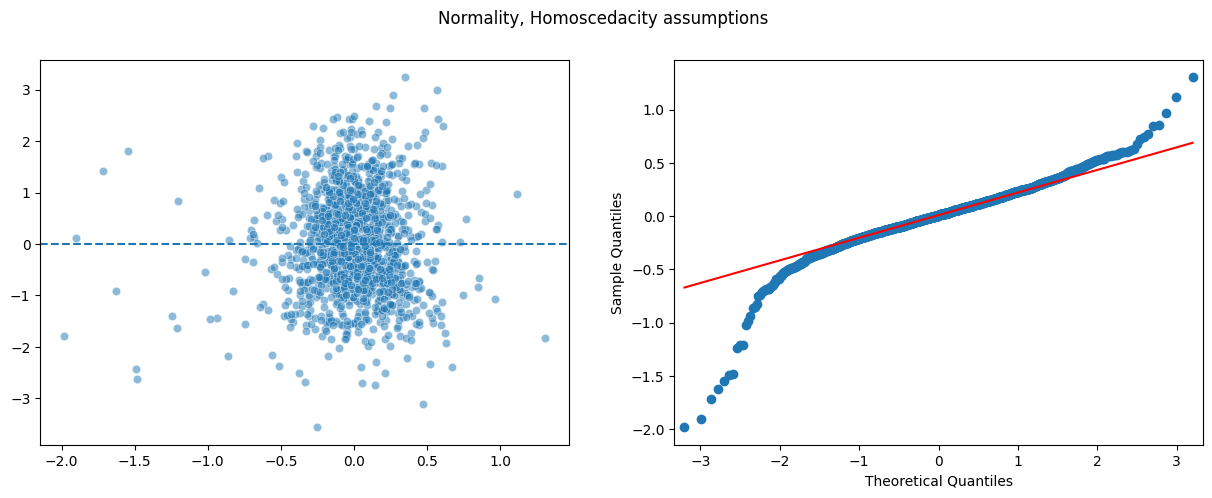

In [506]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.suptitle("Normality, Homoscedacity assumptions")
sns.scatterplot(lmod.resid, lmod.fittedvalues, alpha=0.5, ax=ax1)
ax1.axhline(0, ls='--')
_ = sm.qqplot(lmod.resid, line='q', ax=ax2)

Text(0, 0.5, "Cook's distance")

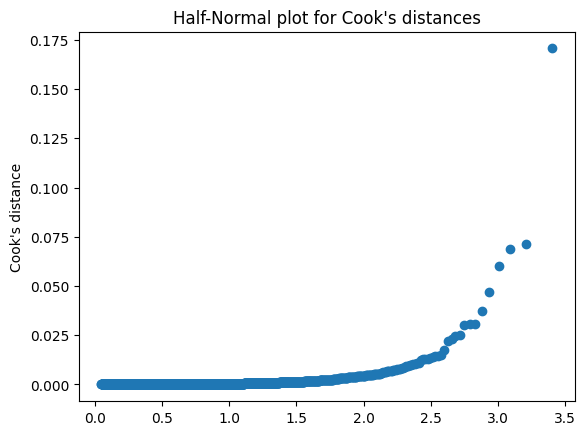

In [510]:
from statsmodels.graphics.regressionplots import influence_plot

diagv = lmod.get_influence()
cooks= pd.Series(diagv.cooks_distance[0], X_tr.index)
n=len(cooks)
ix= np.arange(l,n+l)
halfq = sp.stats.norm.ppf((n+ix)/(2*n+l)),
plt.scatter(halfq, np.sort(cooks))
plt.gca().set_title("Half-Normal plot for Cook's distances")
plt.gca().set_ylabel("Cook's distance")

In [554]:
threshold = 4 / (X_tr.shape[0] - X_tr.shape[1] - 1)
influential_idx = cooks[cooks>threshold].index
print(len(influential_idx))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    display(pd.concat([y_train, X_train], axis=1).loc[influential_idx, ["SalePrice", "OverallQual", "OverallCond", "LotArea", "YearBuilt", "YearRemodAdd", "1stFlrSF", "2ndFlrSF"]])

109


,SalePrice,OverallQual,OverallCond,LotArea,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF
3,140000,7,5,9550,1915,1970,961,756
30,40000,4,4,8500,1920,1950,649,668
88,85000,3,2,8470,1915,1982,1013,0
93,133900,6,6,7200,1910,1998,1260,1031
142,166000,5,4,8520,1952,1952,910,475
144,125000,5,5,9100,1963,1963,1728,0
154,125000,6,5,11340,1923,1950,1200,0
170,128500,5,6,12358,1941,1950,854,0
175,243000,6,7,12615,1950,2001,2158,0
178,501837,9,5,17423,2008,2009,2234,0


In [549]:
X_tr_r = X_tr.drop(index=influential_idx)
y_tr_r = y_tr.drop(index=influential_idx)
lmod2 = sm.OLS(y_tr_r, add_constant(X_tr_r)).fit()
lmod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     385.1
Date:                Sat, 24 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:39:46   Log-Likelihood:                 332.66
No. Observations:                1350   AIC:                            -509.3
Df Residuals:                    1272   BIC:                            -103.1
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.4694      0.154     -3.057      0.002      -0.771      -0.168
num__1stFlrSF                             0.3151      0.066      4.766      0.000       0.185       0.445
num__2ndFlrSF                             0.3581      0.066      5.412      0.000       0.228       0.488
num__BsmtFinSF2                          -0.0121      0.006     -2.003      0.045      -0.024      -0.000
num__BsmtUnfSF                           -0.0746      0.010     -7.251      0.000      -0.095      -0.054
num__EnclosedPorch                        0.0071      0.006      1.140      0.255      -0.005       0.019
num__GarageArea                           0.0307      0.013      2.302      0.021       0.005       0.057
num__GrLivArea                           -0.0588      0.103     -0.573      0.567      -0.260       0.143
num__LotArea                              0.0399      0.010      4.006      0.000       0.020       0.059
num__LotFrontage                          0.0090      0.007      1.202      0.230      -0.006       0.024
num__MasVnrArea                           0.0108      0.007      1.624      0.105      -0.002       0.024
num__OpenPorchSF                          0.0174      0.006      2.689      0.007       0.005       0.030
num__OverallCond                          0.1946      0.031      6.251      0.000       0.134       0.256
num__OverallQual                          0.2051      0.043      4.784      0.000       0.121       0.289
num__ScreenPorch                          0.0222      0.006      3.800      0.000       0.011       0.034
num__TotRmsAbvGrd                         0.1135      0.043      2.610      0.009       0.028       0.199
num__TotalBsmtSF                          0.3277      0.035      9.262      0.000       0.258       0.397
num__WoodDeckSF                           0.0223      0.006      3.607      0.000       0.010       0.034
ord__ExterQual                            0.0235      0.010      2.380      0.017       0.004       0.043
ord__ExterCond                           -0.0071      0.006     -1.154      0.249      -0.019       0.005
ord__BsmtQual                             0.0292      0.010      2.808      0.005       0.009       0.050
ord__KitchenQual                          0.0278      0.009      3.109      0.002       0.010       0.045
ord__FireplaceQu                          0.0306      0.007      4.351      0.000       0.017       0.044
ord__GarageQual                           0.0736      0.023      3.244      0.001       0.029       0.118
ord__GarageCond                           0.0201      0.024      0.841      0.401      -0.027       0.067
ord__HeatingQC                            0.0419      0.007      5.825      0.000       0.028       0.056
ord__Bsmt

In [585]:
cross_val_score(LinearRegression(), X_tr_r, y_tr_r).mean()
r2_score(y_tr[influential_idx], lmod2.predict(add_constant(X_tr.loc[influential_idx])))

0.7309351821400318

### Outliers

In [488]:
huber_t = sm.RLM(y_tr, add_constant(X_tr), M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()

In [491]:
outliers = hub_results.weights.sort_values()[:20].index
X_train.loc[outliers]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
30,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal
632,20,RL,85.0,11900,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2009,WD,Family
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,10,2007,New,Partial
916,20,C (all),50.0,9000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,10,2006,WD,Abnorml
968,50,RM,50.0,5925,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdWo,NaN,0,5,2009,WD,Abnorml
1324,20,RL,75.0,9986,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2007,New,Partial
462,20,RL,60.0,8281,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,GdWo,NaN,0,12,2009,WD,Normal
812,20,C (all),66.0,8712,Grvl,NaN,Reg,Bnk,AllPub,Inside,...,0,0,NaN,NaN,Shed,54,6,2010,WD,Alloca
410,20,RL,68.0,9571,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2009,COD,Abnorml
588,20,RL,65.0,25095,Pave,NaN,IR1,Low,AllPub,Inside,...,60,0,NaN,NaN,NaN,0,6,2009,WD,Partial


In [493]:
from sklearn.linear_model import TheilSenRegressor
tsr = TheilSenRegressor(random_state=42).fit(X_tr, y_tr)

In [495]:
tsr_val_score = cross_val_score(TheilSenRegressor(random_state=42), X_tr, y_tr, cv=5, scoring="r2")
tsr_val_score

array([0.91339281, 0.88114028, 0.90310081, 0.89586733, 0.8833587 ])

### Summary

## EDA
Now the point of interest is whether the observations highlighted by Cook's distance are relevant to prediction

In [564]:
df["IsInfl"] = 0
df.loc[influential_idx, "IsInfl"] = 1

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,price_log,IsInfl,IsInsfl
3,140000,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398,1,1.0
30,40000,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,None,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0,Unf,0,649,649,GasA,TA,N,SBrkr,649,668,0,1317,0,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1920.0,Unf,1,250,TA,Fa,N,0,54,172,0,0,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,10.596635,1,1.0
88,85000,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,TA,N,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,156,0,0,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,11.350407,1,1.0
93,133900,190,C (all),60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,6,1910,1998,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,Fa,Mn,Rec,1046,Unf,0,168,1214,GasW,Ex,N,SBrkr,1260,1031,0,2291,0,1,2,0,4,2,TA,9,Typ,1,Gd,Detchd,1900.0,Unf,2,506,TA,TA,Y,0,0,0,0,99,0,NaN,NaN,NaN,0,11,2007,WD,Normal,11.804849,1,1.0
142,166000,50,RL,71.0,8520,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Artery,Norm,1Fam,1.5Fin,5,4,1952,1952,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,TA,Fa,CBlock,TA,TA,No,Rec,507,Unf,0,403,910,GasA,Fa,Y,SBrkr,910,475,0,1385,0,0,2,0,4,1,TA,6,Typ,0,NaN,Detchd,2000.0,Unf,2,720,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,12.019743,1,1.0
144,125000,90,RM,70.0,9100,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,RRAe,Norm,Duplex,1Story,5,5,1963,1963,Gable,CompShg,HdBoard,HdBoard,BrkFace,336.0,TA,TA,CBlock,TA,TA,No,Rec,1332,Unf,0,396,1728,GasA,TA,Y,SBrkr,1728,0,0,1728,1,0,2,0,6,2,TA,10,Typ,0,NaN,Detchd,1963.0,Unf,2,504,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,11,2006,ConLI,Abnorml,11.736069,1,1.0
154,125000,30,RM,84.0,11340,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,6,5,1923,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,1200,1200,GasA,TA,Y,FuseA,1200,0,0,1200,0,0,1,0,4,1,TA,7,Typ,0,NaN,Detchd,1923.0,Unf,1,312,Fa,Fa,Y,0,0,228,0,0,0,NaN,NaN,NaN,0,3,2006,WD,Family,11.736069,1,1.0
170,128500,50,RM,NaN,12358,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,OldTown,Feedr,Norm,1Fam,1.5Fin,5,6,1941,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,360,Unf,0,360,720,GasA,TA,Y,SBrkr,854,0,528,1382,0,0,1,1,2,1,TA,7,Typ,0,NaN,Detchd,1991.0,Unf,2,660,TA,TA,Y,237,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,11.763684,1,1.0
175,243000,20,RL,84.0,12615,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,1Story,6,7,1950,2001,Gable,CompShg,WdShing,Wd Shng,None,0.0,TA,TA,CBlock,TA,Gd,Av,ALQ,477,Unf,0,725,1202,GasA,TA,Y,SBrkr,2158,0,0,2158,1,0,2,0,4,1,Gd,7,Typ,1,Gd,Attchd,1950.0,Unf,2,576,TA,TA,Y,0,29,39,0,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,12.400817,1,1.0
178,501837,20,RL,63.0,17423,P

<AxesSubplot:xlabel='YrSold', ylabel='count'>

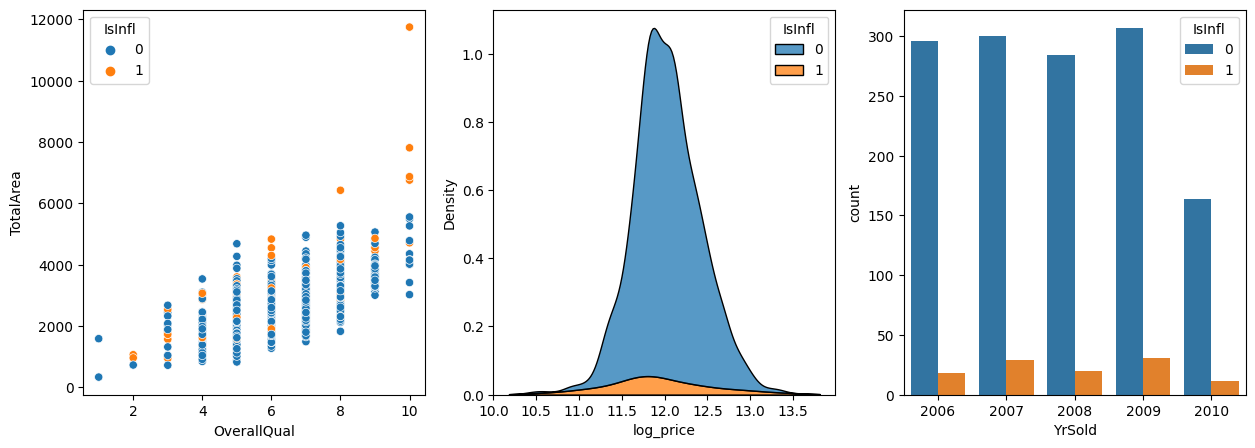

In [580]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

df["TotalArea"] = df["GrLivArea"] + df["TotalBsmtSF"]
df["log_price"] = np.log(df["SalePrice"])
sns.scatterplot(x="OverallQual", y="TotalArea", data=df, hue="IsInfl", ax=ax1)
sns.kdeplot(x="log_price", data=df, hue="IsInfl", multiple="stack", ax=ax2)
sns.countplot(x="YrSold", data=df, ax=ax3, hue="IsInfl")

## Linear

## Interactions

In [ ]:
#https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible
from sklearn.base import RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            print(X.shape)
            X = sm.add_constant(X, has_constant="add")
        print(X.shape)
        return self.results_.predict(X)

In [ ]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from statsmodels.tools import add_constant
from sklearn.metrics import mean_squared_error

y_cat = KBinsDiscretizer(n_bins=10, random_state=42, encode="ordinal").fit_transform(y_train_tr.reshape(-1,1))
split = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = [(train, test) for train, test in split.split(X_train, y_cat)]

lmod = make_pipeline(prep_pipeline, SMWrapper(sm.OLS))
scores = {}

for train, test in folds:
    X = pd.DataFrame(
        prep_pipeline.fit_transform(X_train.iloc[train, :]),
        columns = prep_pipeline.get_feature_names_out()
    )
    Xt = pd.DataFrame(
        prep_pipeline.transform(X_train.iloc[test, :]),
        columns=prep_pipeline.get_feature_names_out()
    )
    y = y_train_tr[train]
    yt = y_train_tr[test]

    for to_interact in powerset(potential_interactions):
        Xi = X.copy()
        Xti = Xt.copy()

        cols = []
        for pred_name in to_interact:
            cols += list(X.columns[X.columns.str.contains(pred_name)])

        for pred_1, pred_2 in combinations(cols, 2):
            Xi[pred_1 + " " + pred_2] = Xi[pred_1]*Xi[pred_2]
            Xti[pred_1 + " " + pred_2] = Xti[pred_1]*Xti[pred_2]

        lmod = sm.OLS(y, add_constant(Xi)).fit()
        if not (to_interact in scores):
            scores[to_interact] = []
        scores[to_interact].append(
            mean_squared_error(lmod.predict(add_constant(Xti, has_constant="add")), yt)
        )
scores = pd.DataFrame(
    scores.values(),
    index = list(scores.keys()),
    columns = ["fold" + str(i) for i in range(len(folds))]
)
scores.shape

In [ ]:
means = scores.mean(axis=1)
print("min cv score:", means.idxmin())
print("Respective MSEs:", means.iloc[0].round(3), means.min().round(3))

In [ ]:
plt.gca().set_title("CV scores for tree-inspired interactions")
plt.gca().set_xlabel("5-fold MSE")
#https://stackoverflow.com/questions/44859415/bar-plot-with-heatmap-color-palette
norm = plt.Normalize(0, means.values.max())
colors = plt.cm.RdYlGn(means.apply(norm ))
sns.barplot(
    x=scores.mean(axis=1), y=scores.index, 
    palette=colors
)

In [ ]:
from sklearn.metrics import mean_squared_error

train, test = folds[3]
lmod1.fit(X, y)
mean_squared_error(lmod1.predict(Xt), yt), mean_squared_error(lmod1.predict(X), y)

In [ ]:
X_tr = pd.DataFrame(
    prep_pipeline.fit_transform(X),
    columns=prep_pipeline.get_feature_names_out()
)
Xt_tr = pd.DataFrame(
    prep_pipeline.transform(Xt),
    columns=prep_pipeline.get_feature_names_out()
)
ll = sm.OLS(y, sm.add_constant(X_tr)).fit()
mean_squared_error(ll.predict(sm.add_constant(Xt_tr)), yt), mean_squared_error(ll.predict(sm.add_constant(X_tr)), y)

In [ ]:
np.linalg.matrix_rank(X_tr)

In [ ]:
from scipy.linalg import qr

Q, R, P = qr(X_tr, mode="economic", pivoting=True)
inv = P.argsort() # reversed order (necessary here)
good_columns = (np.abs(np.diag(R)) > 1e-10)[inv]
X_tr.columns[np.invert(good_columns)]

In [ ]:
X_fullr = X_tr.loc[:, good_columns]
X_fullr.shape

In [ ]:
X_fullr

In [ ]:
from statsmodels.tools import add_constant
lmod = sm.OLS(y_train_tr, add_constant(X_fullr)).fit()
lmod.summary()

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train_tr, lmod.predict(add_constant(X_fullr)))

## Before we start
Dataset size allows us to have a separate validation set. </br>
This is extremely desirable, for otherwise the in

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import KBinsDiscretizer

dicretizer = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
binned_price = dicretizer.fit_transform(y_train_tr.reshape((-1, 1)))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(iter(split.split(X_train, binned_price)))

X = X_train.loc[train_index]
y = y_train.loc[train_index]
X_val = X_train.loc[test_index]
y_val = y_train.loc[test_index]
    
sns.kdeplot(data=y_train2, multiple="stack", label="train")
sns.kdeplot(data=y_val, multiple="stack", label="val")
plt.gca().legend()

In [ ]:
prep_pipeline.fit(X)
X_tr = pd.DataFrame(
    prep_pipeline.transform(X),
    columns = prep_pipeline.get_feature_names_out()
)
X_val_tr = pd.DataFrame(
    prep_pipeline.transform(X_val),
    columns = prep_pipeline.get_feature_names_out()
)

power = PowerTransformer(method="box-cox").fit(y.values.reshape(-1,1))
y_tr = pd.Series(
    power.transform(y.values.reshape(-1, 1)).ravel(),
    index = y.index
)
y_val_tr = pd.Series(
    power.transform(y_val.values.reshape(-1, 1)).ravel(),
    index = y_val.index
)

In [ ]:
print(X_tr.shape)
X_tr.head()

## 1 Group: Area

In [ ]:
def get_lin_indep_cols(X: pd.DataFrame):
    lin_indep_idx = [0]
    i = 1

    while (
        (len(lin_indep_idx) < X.shape[0]) &
        (i < X.shape[1])
    ):
        tmp = X.iloc[:, lin_indep_idx + [i]]

        if np.linalg.matrix_rank(tmp) > len(lin_indep_idx):    
            lin_indep_idx.append(i)

        if i % 100 == 0:
            print(i)
        i += 1
        
    return X.columns[lin_indep_idx]

def get_lin_dep_cols(X: pd.DataFrame):
    lin_indep_cols = get_lin_indep_cols(X)
    lin_dep_columns = np.setdiff1d(X.columns, lin_indep_cols)
    return lin_dep_columns

In [ ]:
from statsmodels.gam.api import GLMGam, BSplines

def fit_gam(X, y, degree=3, df=4):
    bs = BSplines(X, degree=[degree]*X.shape[1], df=[df]*X.shape[1])
    gam_bs = GLMGam(
        y, X,
        smoother=bs
    ).fit()
    return gam_bs
    
def plot_gam(X, y, gam_model):
    n_per_row = 3
    f, axs = plt.subplots(
        int(np.ceil(X.shape[1] / n_per_row)), 
        n_per_row,
        figsize=(20, 20)
    )
    axs = axs.ravel()
    for i in range(X.shape[1]):
        ax = axs[i]
        gam_model.plot_partial(i, cpr=True, ax=ax)
    return f, axs

In [ ]:
class BasedOnLinearRegression(LinearRegression):
    def __init__(
        self, *, based_on, **kwargs):
        self.based_on = based_on
        super(BasedOnLinearRegression, self).__init__(**kwargs)
    
    def fit(self, X, y):
        X_full = np.concatenate([self.based_on, X], axis=1)
        res = super(BasedOnLinearRegression, self).fit(X_full, y)
        self.nonbase_coef_ = self.coef_[self.based_on.shape[1]:]
        return res
    
    def score(self, X, y):
        X_full = np.concatenate([self.based_on, X], axis=1)
        return super(BasedOnLinearRegression, self).score(X_full, y)
    
    def predict(self, X):
        X_full = np.concatenate([self.based_on, X], axis=1)
        return super(BasedOnLinearRegression, self).predict(X_full)
        

In [ ]:
class BasedOnLinearRegression2(LinearRegression):
    def __init__(
        self, *, based_on, **kwargs):
        self.based_on = based_on
        super(BasedOnLinearRegression2, self).__init__(**kwargs)
    
    def fit(self, X, y):
        X_full = pd.concat([self.based_on.loc[X.index, :], X], axis=1)
        res = super(BasedOnLinearRegression2, self).fit(X_full, y)
        self.nonbase_coef_ = self.coef_[self.based_on.shape[1]:]
        return res
    
    def score(self, X, y):
        X_full = pd.concat([self.based_on.loc[X.index, :], X], axis=1)
        return super(BasedOnLinearRegression2, self).score(X_full, y)
    
    def predict(self, X):
        X_full = pd.concat([self.based_on.loc[X.index, :], X], axis=1)
        return super(BasedOnLinearRegression2, self).predict(X_full)
        

In [ ]:
num_cols

In [ ]:
area_preds = [
    "1stFlrSF", "2ndFlrSF", "3SsnPorch", 
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", 
    "EnclosedPorch", "GarageArea", "LotArea",
    "LotFrontage",
    "GrLivArea", "LowQualFinSF", "MasVnrArea",
    "OpenPorchSF", "PoolArea", "ScreenPorch", "TotalBsmtSF", "WoodDeckSF"
]
area_preds_tr = ["num__" + str_ for str_ in area_preds]
print(len(area_preds))
X_area = X_train[area_preds]
X_area

In [ ]:
np.linalg.matrix_rank(X_area)

In [ ]:
(X_train["BsmtFinSF1"] + X_train["BsmtFinSF2"] + X_train["BsmtUnfSF"] == X_train["TotalBsmtSF"]).all()

In [ ]:
(X_train["1stFlrSF"] + X_train["2ndFlrSF"] + X_train["LowQualFinSF"] == X_train["GrLivArea"]).all()

In [ ]:
fullr_area_pred = np.setdiff1d(area_preds, ["GrLivArea", "TotalBsmtSF"])
X_area = X_area[fullr_area_pred]

In [ ]:
X_area_tr = pd.DataFrame(
    num_pipeline.fit_transform(X_area),
    columns=X_area.columns
)

In [ ]:
lmod_area = sm.OLS(y_train_tr, add_constant(X_area_tr)).fit()
lmod_area.summary()

In [ ]:
mean_squared_error(y_train_tr, lmod_area.predict(add_constant(X_area_tr)))

In [ ]:
sns.heatmap(X_area_tr.corr())

In [ ]:
get_vifs(X_area_tr)

This roughlt says that `1stFlrSF`, `BsmtFinSF1` and `BsmtUnfSF` are well explained by the other predictors. </br>
More precisely, removing them from the model doesn't change r2 much. </br>
Still, vifs<5 aren't considered significant. </br>
Conclusion: no severe multicollinearity problems. </br>
This gives us confidence to interpret the hypothesis tests. </br>
In particular, all the predictors, except for `LotArea`, `LotFrontage` and `LowQualFinSf` are found to be significant. </br>
</br>
The fact that `LotArea` is insignificant may be interpreted as having captured all the relevant (to sale price) property on the lot, which is good news.

Finally, let's test the hypotheses that:
- less interpretable `BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnfSF` may be replaced by `TotalBsmtSF`
- less interpretable `1stFlrSF`, `2ndFlrSF`, `LowQualFinSF` may be replaced by `GrLivArea`

In [ ]:
X_area_shrinked1 = X_area.drop(
    columns=[
        "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF",
        "1stFlrSF", "2ndFlrSF", "LowQualFinSF"
    ]
)
X_area_shrinked2 = X_area.drop(
    columns=[
        "1stFlrSF", "2ndFlrSF", "LowQualFinSF"
    ]
)
X_area_shrinked3 = X_area.drop(
    columns=[
        "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF",
    ]
)

X_area_shrinked1 = pd.concat([X_area_shrinked1, X_tr[["num__GrLivArea", "num__TotalBsmtSF"]]], axis=1)
X_area_shrinked2 = pd.concat([X_area_shrinked2, X_tr[["num__GrLivArea"]]], axis=1)
X_area_shrinked3 = pd.concat([X_area_shrinked3, X_tr[["num__TotalBsmtSF"]]], axis=1)

lmod_shrinked1 = sm.OLS(y_train_tr, add_constant(X_area_shrinked1)).fit()
lmod_shrinked2 = sm.OLS(y_train_tr, add_constant(X_area_shrinked2)).fit()
lmod_shrinked3 = sm.OLS(y_train_tr, add_constant(X_area_shrinked3)).fit()


for lmod in [lmod_shrinked1, lmod_shrinked2, lmod_shrinked3]:
    print(sm.stats.anova_lm(
        lmod, 
        lmod_area 
    ), '\n', 'r2', lmod.rsquared.round(4), area_lmod.rsquared.round(2), "\n")

In each case, the difference is statistically significant. </br>
Conclusion: the actual type of bsmt area, and the type of 1s floor area are significant. </br>
With that being said, we only loose about 1% of our explnatory capabilities by omitting them.

### Interactions

#### GAMs 

In [ ]:
from statsmodels.gam.api import GLMGam, BSplines

bs = BSplines(X_area, degree=[3]*X_area.shape[1], df=[4]*X_area.shape[1])
gam_bs = GLMGam(
    y_train_tr, X_area,
    smoother=bs
).fit()

In [ ]:
gam_bs = fit_gam(X_tr[area_preds_tr], y_train_tr)
gam_bs.summary()

In [ ]:
_ = plot_gam(X_tr[area_preds_tr], y_train_tr, gam_bs)

Some of the relations are clearly nonlinear: `OpenPorchSF`, `GarageArea`,  ... </br>
This might serve as a motivation for including higher orders in the first place.

#### Pol features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
pol = PolynomialFeatures(degree=2, include_bias=False).fit(X_area)
X_area_int = pd.DataFrame(
    pol.transform(X_area),
    columns=pol.get_feature_names_out()
)
X_area_int

In [ ]:
lmod_area_int = sm.OLS(y_train_tr, add_constant(X_area_int)).fit()
lmod_area_int.summary()

In [ ]:
print(cross_val_score(LinearRegression(), X_area, y_train_tr, scoring="neg_mean_squared_error").mean())
print(cross_val_score(LinearRegression(), X_area_int, y_train_tr, scoring="neg_mean_squared_error").mean())

In [ ]:
mean_squared_error(y_train_tr, lmod_area_int.predict(add_constant(X_area_int)))

In [ ]:
vifs_area_int = get_vifs(X_area_int)
high_vifs_area_int = vifs_area_int[vifs_area_int>10]
high_vifs_area_int

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

seq_area_int_sel = SequentialFeatureSelector(
    LinearRegression(), n_features_to_select=50, scoring="neg_mean_squared_error", 
    # https://stackoverflow.com/questions/44636370/scikit-learn-gridsearchcv-without-cross-validation-unsupervised-learning
    cv=5,
).fit(X_area_int, y_train_tr)

In [ ]:
X_area_int_only = X_area_int[np.setdiff1d(X_area_int.columns, X_area.columns)]
selected = X_area_int.columns[seq_area_int_sel.get_support()]
selected_int = np.intersect1d(X_area_int_only.columns, selected)
selected_int

In [ ]:
val_scores = []
train_scores = []

for i in range(len(selected_int)):
    X_i = X_area_int[list(X_area.columns) + list(selected_int[:i])]
    print(X_i.columns)
    val_scores.append(
        cross_val_score(
            LinearRegression(), X_i, y_train_tr, cv=10,
        ).mean()
    )
    train_scores.append(
        LinearRegression().fit(X_i, y_train_tr).score(X_i, y_train_tr)
    )

In [ ]:
plt.plot(np.arange(len(val_scores)), np.array(val_scores))
plt.plot(np.arange(len(train_scores)), np.array(train_scores))
plt.gca().set_ylabel("R2")
plt.gca().set_xlabel("# interactions included")
plt.gca().set_ylim([0,1])

This suggests picking 4

In [ ]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(n_alphas=1000, cv=5).fit(X_area_int, y_train_tr)
lasso.alpha_

In [ ]:
selected_lasso = X_area_int.columns[np.argwhere(lasso.coef_ != 0).ravel()]
selected_lasso

In [ ]:
cross_val_score(
    LinearRegression(), X_area_int[selected_lasso], y_train_tr, cv=10,
), cross_val_score(LinearRegression(), X_area, y_train_tr, cv=10)

In [ ]:
area_lmod.ssr, lmod_area_int.ssr

In [ ]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(LinearRegression(), X_area_int[shrink_area_int], y_train_tr, cv=5).mean())
cross_val_score(LinearRegression(), X_area, y_train_tr, cv=5).mean()

Summary: we've discovered significant interactions, included them, keeping an eye on multicollinearity problems. </br>
Resulted in 10% explanatory increase. </br>
$AIC$, $BIC$, $adjR^2$ all suggest a significant improvement in the model.

In [ ]:
X_area = X_area_int[shrink_area_int]

#### Splines
**todo** remove : played badly </br>
CV on the number of knots may further improve the result

In [ ]:
from sklearn.preprocessing import SplineTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

spline = SplineTransformer(include_bias=False)
pipe = make_pipeline(spline, LinearRegression())

gs_spline = GridSearchCV(
    pipe, 
    param_grid={
        "splinetransformer__n_knots": np.arange(3, 10),
        "splinetransformer__knots": ["uniform", "quantile"],
    },
    scoring='r2', 
    cv=10
).fit(X_area, y_train_tr)

In [ ]:
gs_spline.best_score_, gs_spline.best_estimator_.score(X_area, y_train_tr)

In [ ]:
LinearRegression().fit(X_area, y_train_tr).score(X_area, y_train_tr)

In [ ]:
pipe.get_params()

## 2 Group: Condition/Quality

In [ ]:
list(num_cols) + list(ordinal_cols.keys())

In [ ]:
quality_preds = list(ordinal_cols.keys()) + ["OverallCond", "OverallQual"]
quality_preds_tr = ["ord__" + col for col in list(ordinal_cols.keys())] + \
    ["num__" + col for col in ["OverallCond", "OverallQual"]]
print(len(quality_preds))

In [ ]:
np.linalg.matrix_rank(X_tr[quality_preds_tr])

In [ ]:
X_tr[quality_preds_tr].iloc[:, [0, 1]]

In [ ]:
get_lin_dep_cols(X_tr[quality_preds_tr])

In [ ]:
quality_preds.remove("Fence")
quality_preds_tr.remove("ord__Fence")
X_qual = X_tr[quality_preds_tr]

In [ ]:
cond_lmod = sm.OLS(y_train_tr, add_constant(X_qual)).fit()
cond_lmod.summary()

In [ ]:
sns.heatmap(X_qual.corr())

In [ ]:
get_vifs(X_qual)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_tr[quality_preds_tr])
pca.explained_variance_ratio_.round(3)

In [ ]:
print(-np.sort(-np.abs(pca.components_[0])))
np.array(quality_preds_tr)[np.argsort(-np.abs(-pca.components_[0]))]

As a result, a good idea here is to remove `GarageCond`

In [ ]:
quality_preds.remove("GarageCond")
quality_preds_tr.remove("ord__GarageCond")
X_qual = X_tr[quality_preds_tr]

In [ ]:
cond_lmod2 = sm.OLS(y_train_tr, add_constant(X_tr[quality_preds_tr])).fit()
cond_lmod2.summary()

In [ ]:
get_vifs(X_qual)

Now that multicollinearity has vanished, we could argue that the following preds are insignificant:
- `ord__PoolQC`;
- `ord__FireplaceQu`;
- `ord__Utilities`;
- `ord__BsmtFinType2`;

Of course, there is a small problem with such an argument (multiple testing), so to be more precise:

In [ ]:
shrink_qual_preds = list(
    set(quality_preds_tr) - set([
        "ord__PoolQC", "ord__ExterCond", 
        "ord__Utilities", "ord__BsmtFinType2"
    ])
)
cond_lmod_shrink = sm.OLS(y_train_tr, X_tr[shrink_qual_preds]).fit()

sm.stats.anova_lm(cond_lmod_shrink, cond_lmod2)

In [ ]:
X_qual = X_tr[shrink_qual_preds]

### Interactions
For this group we do not expect there being any nonlinear realtionships

In [ ]:
gam_bs = fit_gam(X_qual, y_train_tr)
gam_bs.summary()

In [ ]:
mean_squared_error(y_train_tr, gam_bs.predict(exog=np.asarray(X_qual), exog_smooth=np.asarray(X_qual)))

In [ ]:
_ = plot_gam(X_qual, y_train_tr, gam_bs)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
pol = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit(X_qual)
X_qual_int = pd.DataFrame(
    pol.transform(X_qual),
    columns=pol.get_feature_names_out()
)

X_qual_int

In [ ]:
lmod_qual_int = sm.OLS(y_train_tr, add_constant(X_qual_int)).fit()
print(lmod_qual_int.ssr, cond_lmod2.ssr)
lmod_qual_int.summary()

That is more contreversial: `BIC` is higher, `AIC` is lower, the difference in `R2` is rather negligent. </br>
Since such a transformation would considerably decrease explainablitity, I've decided to not apply it.

## Group 3: Rest

In [ ]:
onehot_cols

In [ ]:
onehot_cols_tr = onehot_cat_pipeline.fit(X_train[onehot_cols]).get_feature_names_out()
onehot_cols_tr = ["hot__" + col_name for col_name in onehot_cols_tr]
X_rest = X_tr[onehot_cols_tr]

In [ ]:
dep_cols = get_lin_dep_cols(X_rest)
dep_cols

**TODO:** Why are those lin. dep.? How do I get the correspoding linear combination? iteratively solve system of linear equations

In [ ]:
onehot_cols_tr = list(set(onehot_cols_tr) - set(dep_cols))
X_rest = X_tr[onehot_cols_tr]

In [ ]:
rest_lmod = sm.OLS(y_train_tr, X_rest).fit()
rest_lmod.summary()

In [ ]:
vifs = get_vifs(X_rest)
high_vifs = vifs[vifs > 10]
print(len(high_vifs))
high_vifs

In [ ]:
noncollin_preds = list(set(X_rest.columns) - set(high_vifs.index))
lmod_based = BasedOnLinearRegression(based_on=X_tr[noncollin_preds])

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

seq_sel = SequentialFeatureSelector(
    lmod_based, n_features_to_select=10, scoring="r2", 
    # https://stackoverflow.com/questions/44636370/scikit-learn-gridsearchcv-without-cross-validation-unsupervised-learning
    cv=[(slice(None), slice(None))],
).fit(X_tr[high_vifs.index], y_train_tr)

In [ ]:
selected = high_vifs.index[seq_sel.get_support()]
selected

In [ ]:
temp_preds = noncollin_preds.copy()
ssrs = []
f_pvals = []
high_vifs_len = []
for i in range(len(selected)+1):
    lmodi = sm.OLS(y_train_tr, add_constant(X_tr[temp_preds])).fit()
    anovai = sm.stats.anova_lm(
        lmodi,
        rest_lmod
    )
    ssrs.append(lmodi.ssr)
    f_pvals.append(anovai.loc[1, "Pr(>F)"])
    temp_vifs = get_vifs(X_tr[temp_preds])
    high_vifs_len.append(len(temp_vifs[temp_vifs>10]))
    try:
        temp_preds.append(selected[i])
    except:
        pass
    
pd.DataFrame(
    {"f_pvals":f_pvals, "ssrs":ssrs, "high_vifs_len": high_vifs_len}
).round(2)

We'll have to loose some evidence in order to deal with multicollinearity

In [ ]:
lmod1 = sm.OLS(y_train_tr, X_tr[noncollin_preds + list(selected[:1])]).fit()
lmod2 = sm.OLS(y_train_tr, X_tr[noncollin_preds + list(selected[:2])]).fit()
sm.stats.anova_lm(
    lmod1,
    lmod2
)

Conclusion: we'll include first 2 selected predictors.

In [ ]:
onehot_cols_tr = noncollin_preds + list(selected[:2])
X_rest = X_tr[onehot_cols_tr]

In [ ]:
lmod_hot_cut = sm.OLS(y_train_tr, add_constant(X_rest)).fit()
lmod_hot_cut.summary()

In [ ]:
X_rest.shape

### Interactions

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
pol = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit(X_rest)
X_rest_int = pd.DataFrame(
    pol.transform(X_rest),
    columns=pol.get_feature_names_out()
)

X_rest_int

In [ ]:
np.linalg.matrix_rank(X_rest)

In [ ]:
INT_FILE_NAME ="lin_indep_cols_int.joblib"
try:
    int_file = open(INT_FILE_NAME, 'rb')
    lin_indep_int_cols = load(int_file)
except (EOFError, FileNotFoundError):
    lin_indep_int_cols = get_lin_indep_cols(X_rest_int)
    int_file = open(INT_FILE_NAME, 'wb')
    dump(lin_indep_int_cols, int_file)

In [ ]:
np.linalg.matrix_rank(X_rest_int[lin_indep_int_cols])

In [ ]:
X_rest_int = X_rest_int.loc[:, lin_indep_int_cols]
X_rest_int_only = X_rest_int.loc[:, list(set(X_rest_int.columns) - set(X_rest))]
X_rest_int_only.shape

In [ ]:
sm.OLS(y_train_tr, X_rest_int).fit().summary()

In [ ]:
based_rest = BasedOnLinearRegression(based_on=X_rest)

FORW_FILE_NAME = "forw_rest_int2.joblib"
try:
    forw_file = open(FORW_FILE_NAME, 'rb')
    seq_sel_rest_int = load(forw_file)
except (EOFError, FileNotFoundError):
    seq_sel_rest_int = SequentialFeatureSelector(
        based_rest, n_features_to_select=50, scoring="r2", 
        cv=[(slice(None), slice(None))],
    ).fit(X_rest_int_only, y_train_tr)
    forw_file = open(FORW_FILE_NAME, 'wb')
    dump(seq_sel_rest_int, forw_file)

In [ ]:
selected_seq = X_rest_int_only.columns[seq_sel_rest_int.get_support()]
selected_seq

In [ ]:
shrink_rest_int = list(X_rest.columns) + list(selected_seq)
lmod_rest_int = sm.OLS(y_train_tr, add_constant(X_rest_int[shrink_rest_int])).fit()
lmod_rest_int.summary()

In [ ]:
mean_squared_error(y_train_tr, lmod_rest_int.predict(add_constant(X_rest_int[shrink_rest_int])))

In [ ]:
rest_lmod.ssr, lmod_rest_int.ssr

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

print(cross_val_score(Lasso(), X_rest_int[shrink_rest_int], y_train_tr, cv=5).round(2))
cross_val_score(Lasso(), X_rest, y_train_tr, scoring="neg_mean_squared_error", cv=5)

Summary: as before, we've discovered significant interactions, included them, keeping an eye on multicollinearity problems. </br>
Resulted in 8% explanatory increase. </br>
$AIC$, $BIC$, $adjR^2$ all suggest a significant improvement in the model.

In [ ]:
X_rest = X_rest_int[shrink_rest_int]

### Joining

In [ ]:
X_area_rest = pd.concat([X_area, X_rest], axis=1)
X_qual_rest = pd.concat([X_qual, X_rest], axis=1)
X_area_qual = pd.concat([X_area, X_qual], axis=1)
X_full = pd.concat([X_area_rest, X_qual], axis=1)

In [ ]:
relevant_metric = [
    "aic", "bic", "rsquared", 
    "rsquared_adj", "ssr", "condition_number"
]

for name, X in zip(
    ["area_rest", "qual_rest", "area_qual", "full"], 
    [X_area_rest, X_qual_rest, X_area_qual, X_full]
):
    lmodi = sm.OLS(
        y_train_tr, 
        add_constant(X)
    ).fit()
    
    print(name)
    for metric in relevant_metric:
        print(metric + ": " + str(getattr(lmodi, metric).round(2)))
    print("\n")
    

In [ ]:
vifs_join = get_vifs(X_area_qual)
high_vifs_join = vifs_join[vifs_join > 5]
high_vifs_join

In [ ]:
lmod_full = sm.OLS(
    y_train_tr, 
    add_constant(X_full)
).fit()
lmod_full.summary()

In [ ]:
vifs_full = get_vifs(X_full)
high_vifs_full = vifs_full[vifs_full>5].sort_values(ascending=False)
high_vifs_full

In [ ]:
for i in range(len(high_vifs_full.index)):
    X_full_i = X_full[list(set(X_full.columns) - set(high_vifs_full.index[:i]))] 
    lmod_full_temp = sm.OLS(
        y_train_tr, 
        add_constant(X_full_i)
    ).fit()

    print(f"cut [:{i}]:")
    for metric in relevant_metric:
        print(metric + ": " + str(getattr(lmod_full_temp, metric).round(2)))
    print("\n")

In [ ]:
X_full = X_full[np.setdiff1d(X_full.columns, high_vifs_full.index[:4]]

As it turns out, area is explained well by both expert condition estimates and other included categories. </br>
That is understandable, and is expected. </br>
Should I deal with multicollinearity in this case? </br>
>The presence of multicollinearity doesn't affect the efficiency of extrapolating the fitted model to new data provided that the predictor variables follow the same pattern of multicollinearity in the new data as in the data on which the regression model is based.

We have quite a few DFs left, which suggest that we might try inter-group interactions.

In [ ]:
pol = PolynomialFeatures(include_bias=False, interaction_only=True)

pol.fit(X_tr[area_preds_tr])
area_int_cols = pol.get_feature_names_out()

pol.fit(X_tr[onehot_cols_tr])
rest_int_cols = pol.get_feature_names_out()

comb = np.concatenate([area_int_cols, rest_int_cols])

pol.fit(X_area_rest)
area_rest_int_cols = pol.get_feature_names_out()
# do i need?
#https://stackoverflow.com/questions/46261671/use-numpy-setdiff1d-keeping-the-order
area_rest_only_int_cols = area_rest_int_cols[~np.in1d(area_rest_int_cols, comb)]

area_rest_int = pd.DataFrame(
    pol.transform(X_area_rest),
    columns=pol.get_feature_names_out()
)[area_rest_only_int_cols]

In [ ]:
area_rest_int.columns

## Submission

In [ ]:
X_test = pd.read_csv("./test.csv")
transformed_price_predict = boost_gs.predict(X_test)
price_predict = power_transformer.inverse_transform(transformed_price_predict.reshape(-1, 1)).ravel()
assert (price_predict > 0).all()
pred = pd.DataFrame({"SalePrice": price_predict}, index=X_test["Id"])
display(pred)
pred.to_csv("pred.csv")

In [599]:
X_test = pd.read_csv("./test.csv")
X_test_tr = pd.DataFrame(
    best_r2adj_est[:-1].transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)
log_pred = lmod2.predict(add_constant(X_test_tr.loc[:, good_columns]))
pred = power_transformer.inverse_transform(log_pred.values.reshape(-1, 1)).ravel()
pred = pd.DataFrame({"SalePrice": pred}, index=X_test["Id"])
pred.to_csv("main_bulk_pred.csv")

C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 9, 10, 11, 13, 14, 15, 26, 27, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [609]:
pred_ridge = power_transformer.inverse_transform(ridge_gs.predict(X_test).reshape(-1,1)).ravel()
pred_ridge = pd.DataFrame({"SalePrice": pred_ridge}, index=X_test["Id"])
pred_ridge.to_csv("ridge_pred.csv")

C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 9, 10, 11, 13, 14, 15, 26, 27, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
